**(1.MADDE)Her bir kenar noktasından X uzunluğunda çizgi alınarak (Kenar noktası merkezde olacak şekilde) Hog ile kodlandı. Bulunan kenar ile label kenarı karşılaştırıldı IoU sonucu gösterildi.**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.feature import hog
from skimage import measure
import pickle
import os


# Benzersiz vektörleri bir dosyaya kaydetmek için fonksiyon
def SaveUniqueVectors(vectors, filename="unique_vectors.pkl"):
    """
    Benzersiz vektörleri bir dosyaya kaydeder. Dosya yoksa oluşturur.

    Parameters:
    - vectors: Kaydedilecek vektörler (numpy array)
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)
    """
    if not os.path.exists(filename):
        print(f"{filename} oluşturuluyor...")

    with open(filename, "wb") as f:
        pickle.dump(vectors, f)
    print(f"{len(vectors)} vektör {filename} dosyasına kaydedildi.")

# Benzersiz vektörleri bir dosyadan yüklemek için fonksiyon
def LoadUniqueVectors(filename="unique_vectors.pkl"):
    """
    Dosyadan benzersiz vektörleri yükler.

    Parameters:
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)

    Returns:
    - vectors: Yüklenen vektörler (numpy array)
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Dosya bulunamadı: {filename}")

    with open(filename, "rb") as f:
        vectors = pickle.load(f)
    print(f"{len(vectors)} vektör {filename} dosyasından yüklendi.")
    return vectors


def GetImageLabel(imgStr, labelStr, draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image file {imgStr} not found.")
    img = ConvertAndNormalize(img)

    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)
    if label is None:
        raise FileNotFoundError(f"Label file {labelStr} not found.")

    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(imgStr)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(labelStr)
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    return img, label

def ConvertAndNormalize(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    min_val = np.min(img)
    max_val = np.max(img)
    if max_val == min_val:
        raise ValueError("Image has no intensity variation.")

    normalized_img = ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return normalized_img

def Drawing(img, EdgePoints=None, EdgeLines=None, title=None, circle_radius=2):
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if EdgePoints is not None:
        for point in EdgePoints:
            x, y = int(point[1]), int(point[0])
            cv2.circle(output_img, (x, y), circle_radius, (0, 0, 255), -1)

    if EdgeLines is not None:
        for line in EdgeLines:
            start_point = line["StartPointYX"]
            stop_point = line["StopPointYX"]
            cv2.line(output_img, start_point[::-1], stop_point[::-1], color=(255, 255, 0), thickness=1)

    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (15 * aspect_ratio, 15)

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()

#BWBOUNDARY ile label kenarlarının bulunması
def GetLabelEdgePoints(img, sparsity_factor=1, circle_radius=1, draw=False):
    contours = measure.find_contours(img, level=0.5)
    boundary_points = np.vstack(contours)

    if sparsity_factor > 1:
        boundary_points = boundary_points[::sparsity_factor]

    if draw:
        Drawing(img, EdgePoints=boundary_points, circle_radius=circle_radius)

    return boundary_points.astype(int)

#CANNY ile test görselinde organ kenarlarının tespiti
def GetCannyEdgePoints(img, sparsity_factor=1, draw=False):
    blurimg = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurimg, 40, 190)
    CannyEdgePoints, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    EdgePoints = []
    for ObjPoints in CannyEdgePoints:
        EdgePoints += [(point[0][1], point[0][0]) for i, point in enumerate(ObjPoints) if i % sparsity_factor == 0]

    if draw:
        Drawing(img, EdgePoints=EdgePoints)

    return EdgePoints

#Burda kenar noktalarına çizgi çekiyoruz 45 derecelik açılarla aynı noktadan 8 tane çizgi çekiliyor kenar noktası merkez olacak şekilde
def GetEdgeLines(img, EdgePoints, line_length=20, draw=True):
    EdgeLines = []
    for point in EdgePoints:
        y, x = point
        for angle in range(0, 360, 45):
            end_x = int(x + line_length * math.cos(math.radians(angle)))
            end_y = int(y + line_length * math.sin(math.radians(angle)))
            if 0 <= end_x < img.shape[1] and 0 <= end_y < img.shape[0]:
                EdgeLines.append({"StartPointYX": (y, x), "StopPointYX": (end_y, end_x)})

    if draw:
        Drawing(img, EdgeLines=EdgeLines)

    return EdgeLines

#Burda çekilen her bir çizgi için vektörler oluşturuluyor 
def LineToVector(line, img, PatchSize, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1)):
    y1, x1 = line["StartPointYX"]
    y2, x2 = line["StopPointYX"]
    
    #Burda çizgi üzerine noktalar koyarak görüntü boyutunu aşıp aşmadığını kontrol ediyoruz
    num_points = PatchSize
    x_vals = np.linspace(x1, x2, num_points).astype(int)
    y_vals = np.linspace(y1, y2, num_points).astype(int)

    #Burda eğer çizgi görüntü sınırlarını aşıyorsa hata verecek
    if not (0 <= x_vals.min() < img.shape[1] and 0 <= y_vals.min() < img.shape[0]):
        raise ValueError("Interpolasyon koordinatları görüntü sınırları dışında!")

    line_patch = img[y_vals, x_vals]

    #Çizgilerin kontrolü
    if line_patch.ndim < 2:
        line_patch = line_patch.reshape(-1, 1)

    if line_patch.shape != (PatchSize, PatchSize):
        padded_patch = np.zeros((PatchSize, PatchSize), dtype=np.float32)
        padded_patch[:line_patch.shape[0], :line_patch.shape[1]] = line_patch
        line_patch = padded_patch

    # HOG ile vektöre dönüştür
    vec, _ = hog(line_patch, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    return vec

#Her çizgi vektörünü bir listede tutuyoruz
def EdgeLines2EdgeVecs(EdgeLines, img, PatchSize, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), draw=False):
    EdgeVecs = []
    for line in EdgeLines:
        vec = LineToVector(line, img, PatchSize, orientations, pixels_per_cell, cells_per_block)
        EdgeVecs.append(vec)

    EdgeVecs = np.squeeze(np.array(EdgeVecs))

    if draw:
        print("EdgeVecs boyutu:", EdgeVecs.shape)

    return EdgeVecs

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
    return dot_product / (norm_vec1 * norm_vec2)

def FindUniqueVectors(vectors, threshold=0.9):
    unique_indices = []
    for i, vector in enumerate(vectors):
        is_unique = True
        for j in unique_indices:
            similarity = cosine_similarity(vector, vectors[j])
            if similarity > threshold:
                is_unique = False
                break
        if is_unique:
            unique_indices.append(i)
    return unique_indices

def GetUniqueLinesVectors(EdgeLines, EdgeVecs, UniqueInds):
    UniqueLines = [EdgeLines[idx] for idx in UniqueInds]
    Vectors = [EdgeVecs[idx] for idx in UniqueInds]
    Vectors = np.squeeze(np.array(Vectors))
    return UniqueLines, Vectors

def VisualizeUniquePatches(img, UniqueLines, PatchSize, max_patches=20, title=None):
    """
    Unique vektörlerin patch'lerini görselleştirir.

    Parameters:
    - img: Orijinal görüntü
    - UniqueLines: Unique kenar vektörlerine karşılık gelen çizgiler
    - PatchSize: Görüntüden çıkarılacak patch boyutu
    - max_patches: Bir seferde gösterilecek maksimum patch sayısı
    - title: Plot başlığı (isteğe bağlı)
    """
    num_patches = min(len(UniqueLines), max_patches)  # Maksimum gösterim sayısını uygula

    # Her bir patch'i göstermek için bir subplot düzeni ayarla
    cols = min(5, num_patches)  # En fazla 5 sütun göster
    rows = (num_patches + cols - 1) // cols

    plt.figure(figsize=(15, rows * 3))

    for i, line in enumerate(UniqueLines[:num_patches]):  # Sadece max_patches kadar patch al
        y1, x1 = line["StartPointYX"]
        y2, x2 = line["StopPointYX"]

        # Patch'in koordinatlarını belirle
        x_vals = np.linspace(x1, x2, PatchSize).astype(int)
        y_vals = np.linspace(y1, y2, PatchSize).astype(int)

        # Patch'in görüntü sınırlarının dışına çıkmamasını sağla
        x_vals = np.clip(x_vals, 0, img.shape[1] - 1)
        y_vals = np.clip(y_vals, 0, img.shape[0] - 1)

        # Patch'i al ve boyutunu kontrol et
        patch = img[y_vals, :][:, x_vals]

        if patch.ndim == 1:
            patch = patch.reshape(-1, 1)  # Tek boyutluysa iki boyuta çıkar

        # Patch boyutu uygun değilse doldur
        if patch.shape != (PatchSize, PatchSize):
            padded_patch = np.zeros((PatchSize, PatchSize), dtype=img.dtype)
            padded_patch[:patch.shape[0], :patch.shape[1]] = patch
            patch = padded_patch

        # Görüntüle
        plt.subplot(rows, cols, i + 1)
        plt.imshow(patch, cmap="gray")
        plt.axis("off")
        plt.title(f"Patch {i+1}")

    if title:
        plt.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Örnek kullanım:
# VisualizeUniquePatches(img, UniqueLines, PatchSize=20, max_patches=20, title="Unique Patch Visualization")

def Match(img_UniqueVecs, test_img_EdgeVecs, test_img_EdgePoints, threshold=0.9):
    """
    Eşleşen kenar noktalarını ve bunlara ait vektörleri döndürür.

    Parameters:
    - img_UniqueVecs: Referans görüntünün benzersiz kenar vektörleri
    - test_img_EdgeVecs: Test görüntüsünün kenar vektörleri
    - test_img_EdgePoints: Test görüntüsünün kenar noktaları
    - threshold: Kosinüs benzerlik eşik değeri (0 ile 1 arasında)

    Returns:
    - TrueEdgePoints: Eşleşen kenar noktaları
    - TrueEdgeVecs: Eşleşen vektörler
    """
    TrueEdgePoints = []
    TrueEdgeVecs = []

    for i, test_vec in enumerate(test_img_EdgeVecs):
        if i >= len(test_img_EdgePoints):
            
            continue
        
        if len(test_vec) != len(img_UniqueVecs[0]):
            raise ValueError(f"Vektör boyutları eşleşmiyor! Test Vec: {len(test_vec)}, Unique Vec: {len(img_UniqueVecs[0])}")

        max_similarity = max(cosine_similarity(test_vec, unique_vec) for unique_vec in img_UniqueVecs)
        
        if max_similarity >= threshold:
            TrueEdgePoints.append(test_img_EdgePoints[i])
            TrueEdgeVecs.append(test_vec)

    return TrueEdgePoints, TrueEdgeVecs


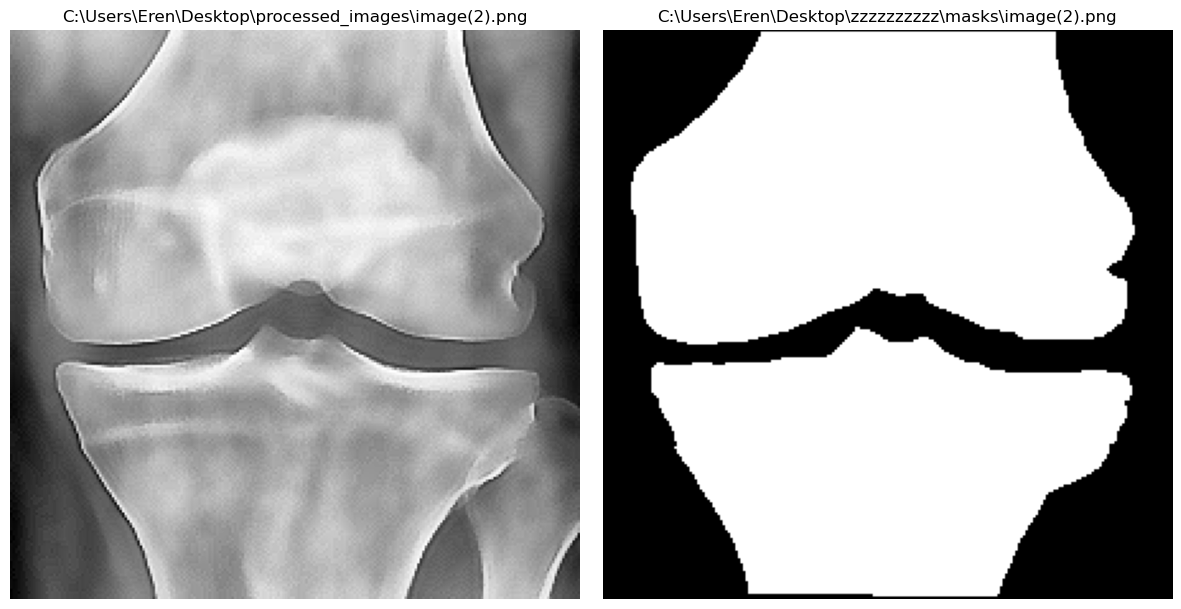

In [4]:
# img ve label gorselleri al
img, label = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(2).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(2).png',draw=True)   

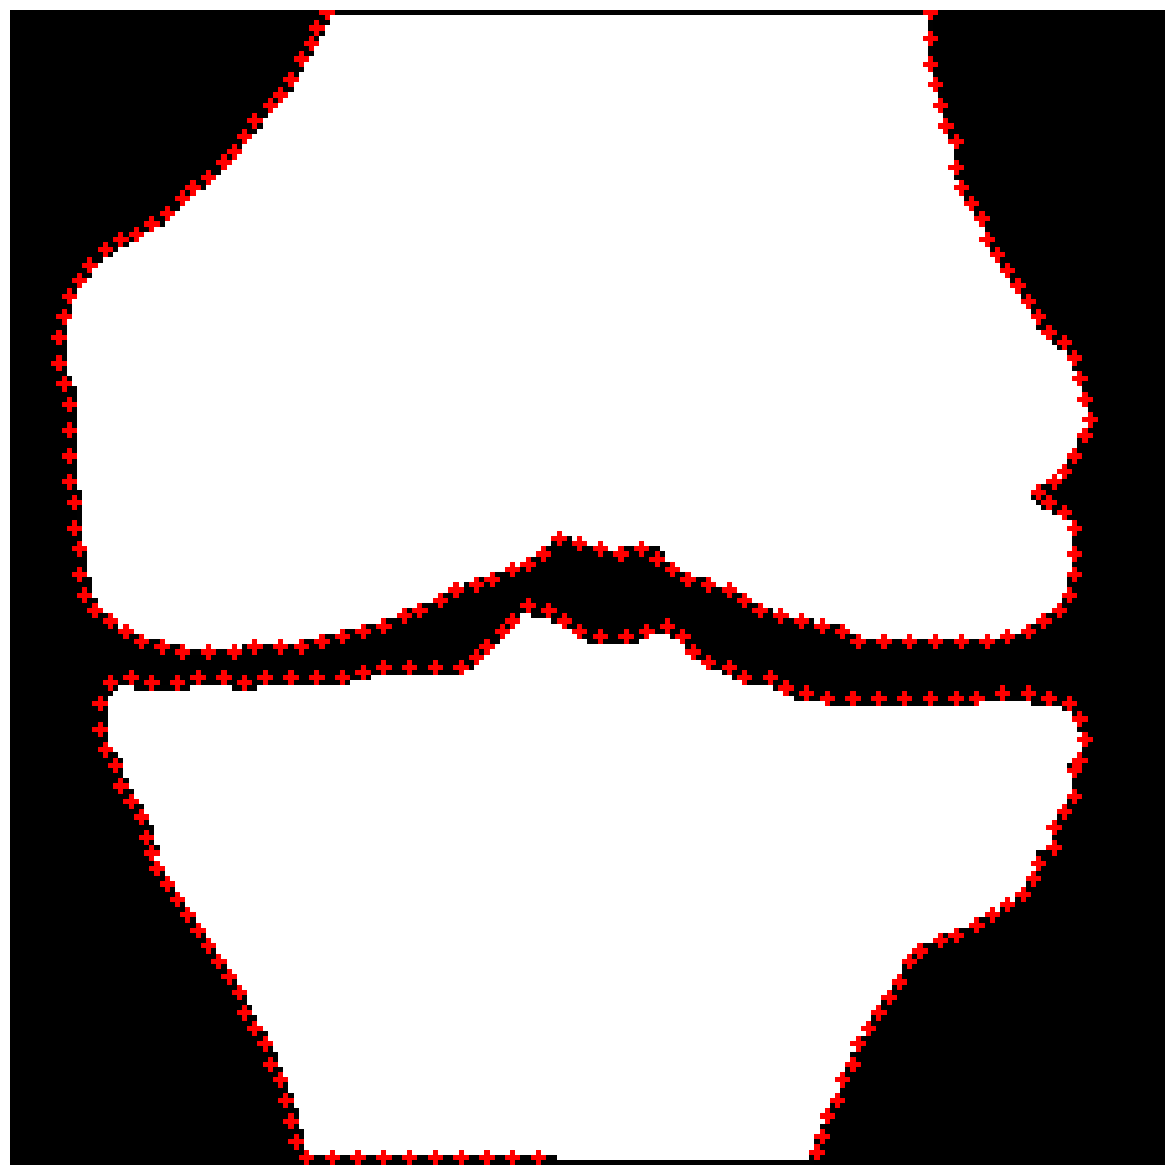

In [5]:
# 2. Kenar noktalarını elde et
img_EdgePoints = GetLabelEdgePoints(label, sparsity_factor=5, draw=True)

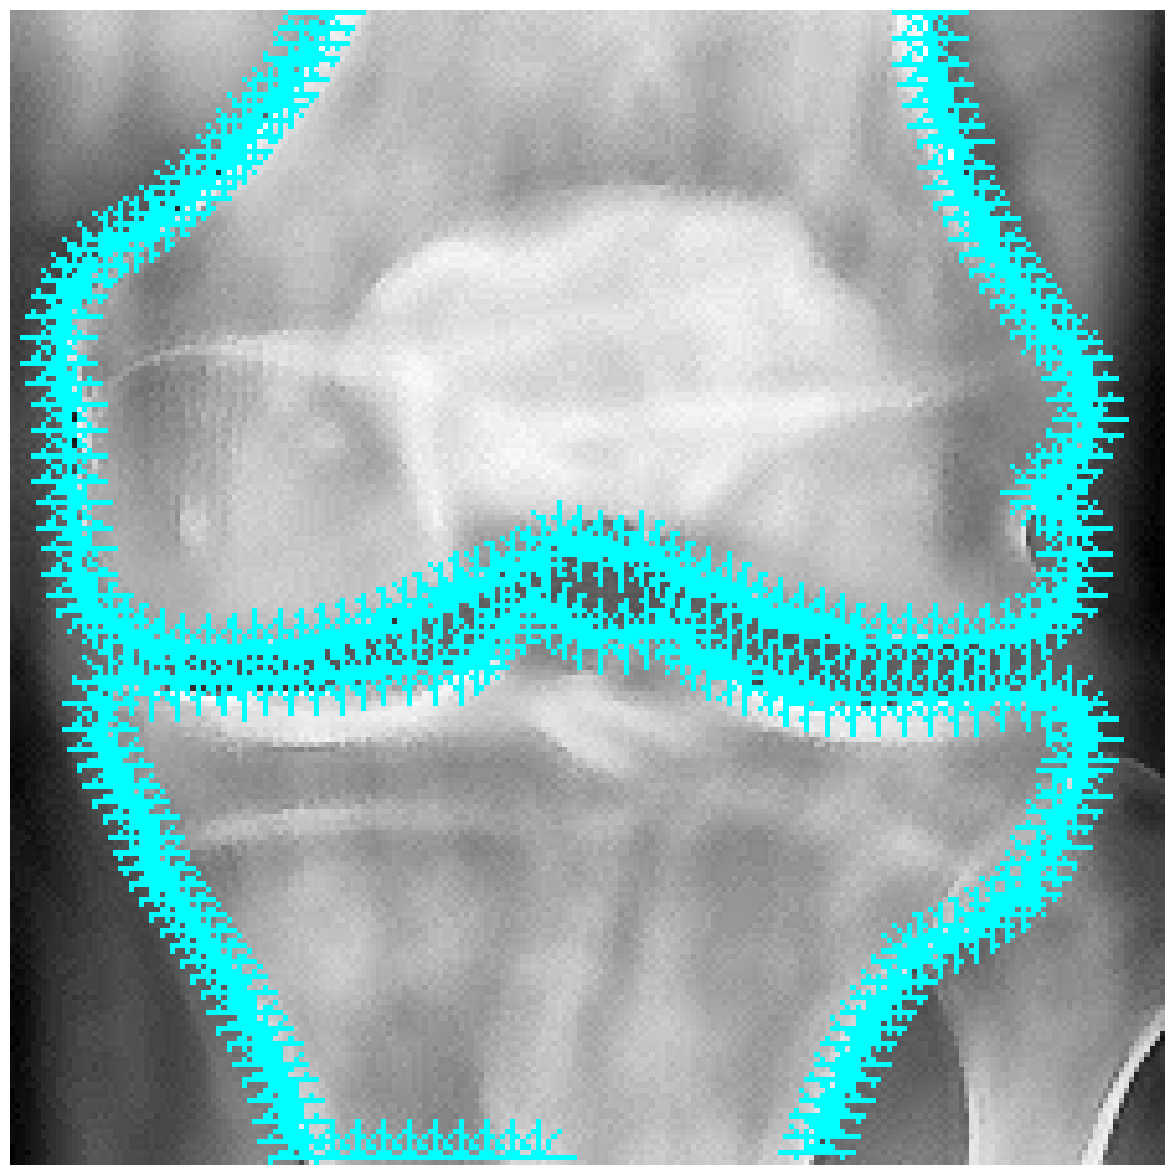

In [6]:
# 3. Kenar noktalarından çizgiler oluştur
img_EdgeLines = GetEdgeLines(img, img_EdgePoints, line_length=7, draw=True)

In [7]:
# 4. Çizgileri vektöre dönüştür
img_EdgeVecs = EdgeLines2EdgeVecs(img_EdgeLines, img, PatchSize=12, draw=True)

EdgeVecs boyutu: (1802, 72)


In [8]:
# 5. Benzersiz vektörleri bul
unique_indices = FindUniqueVectors(img_EdgeVecs, threshold=10)

In [9]:
# 6. Benzersiz çizgileri ve vektörleri al
unique_lines = [img_EdgeLines[i] for i in unique_indices]
unique_vecs = img_EdgeVecs[unique_indices]
SaveUniqueVectors(unique_vecs, filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\kenar_unique_vectors.pkl")


C:\Users\Eren\Desktop\hog_kenar_kayit\kenar_unique_vectors.pkl oluşturuluyor...
1802 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\kenar_unique_vectors.pkl dosyasına kaydedildi.


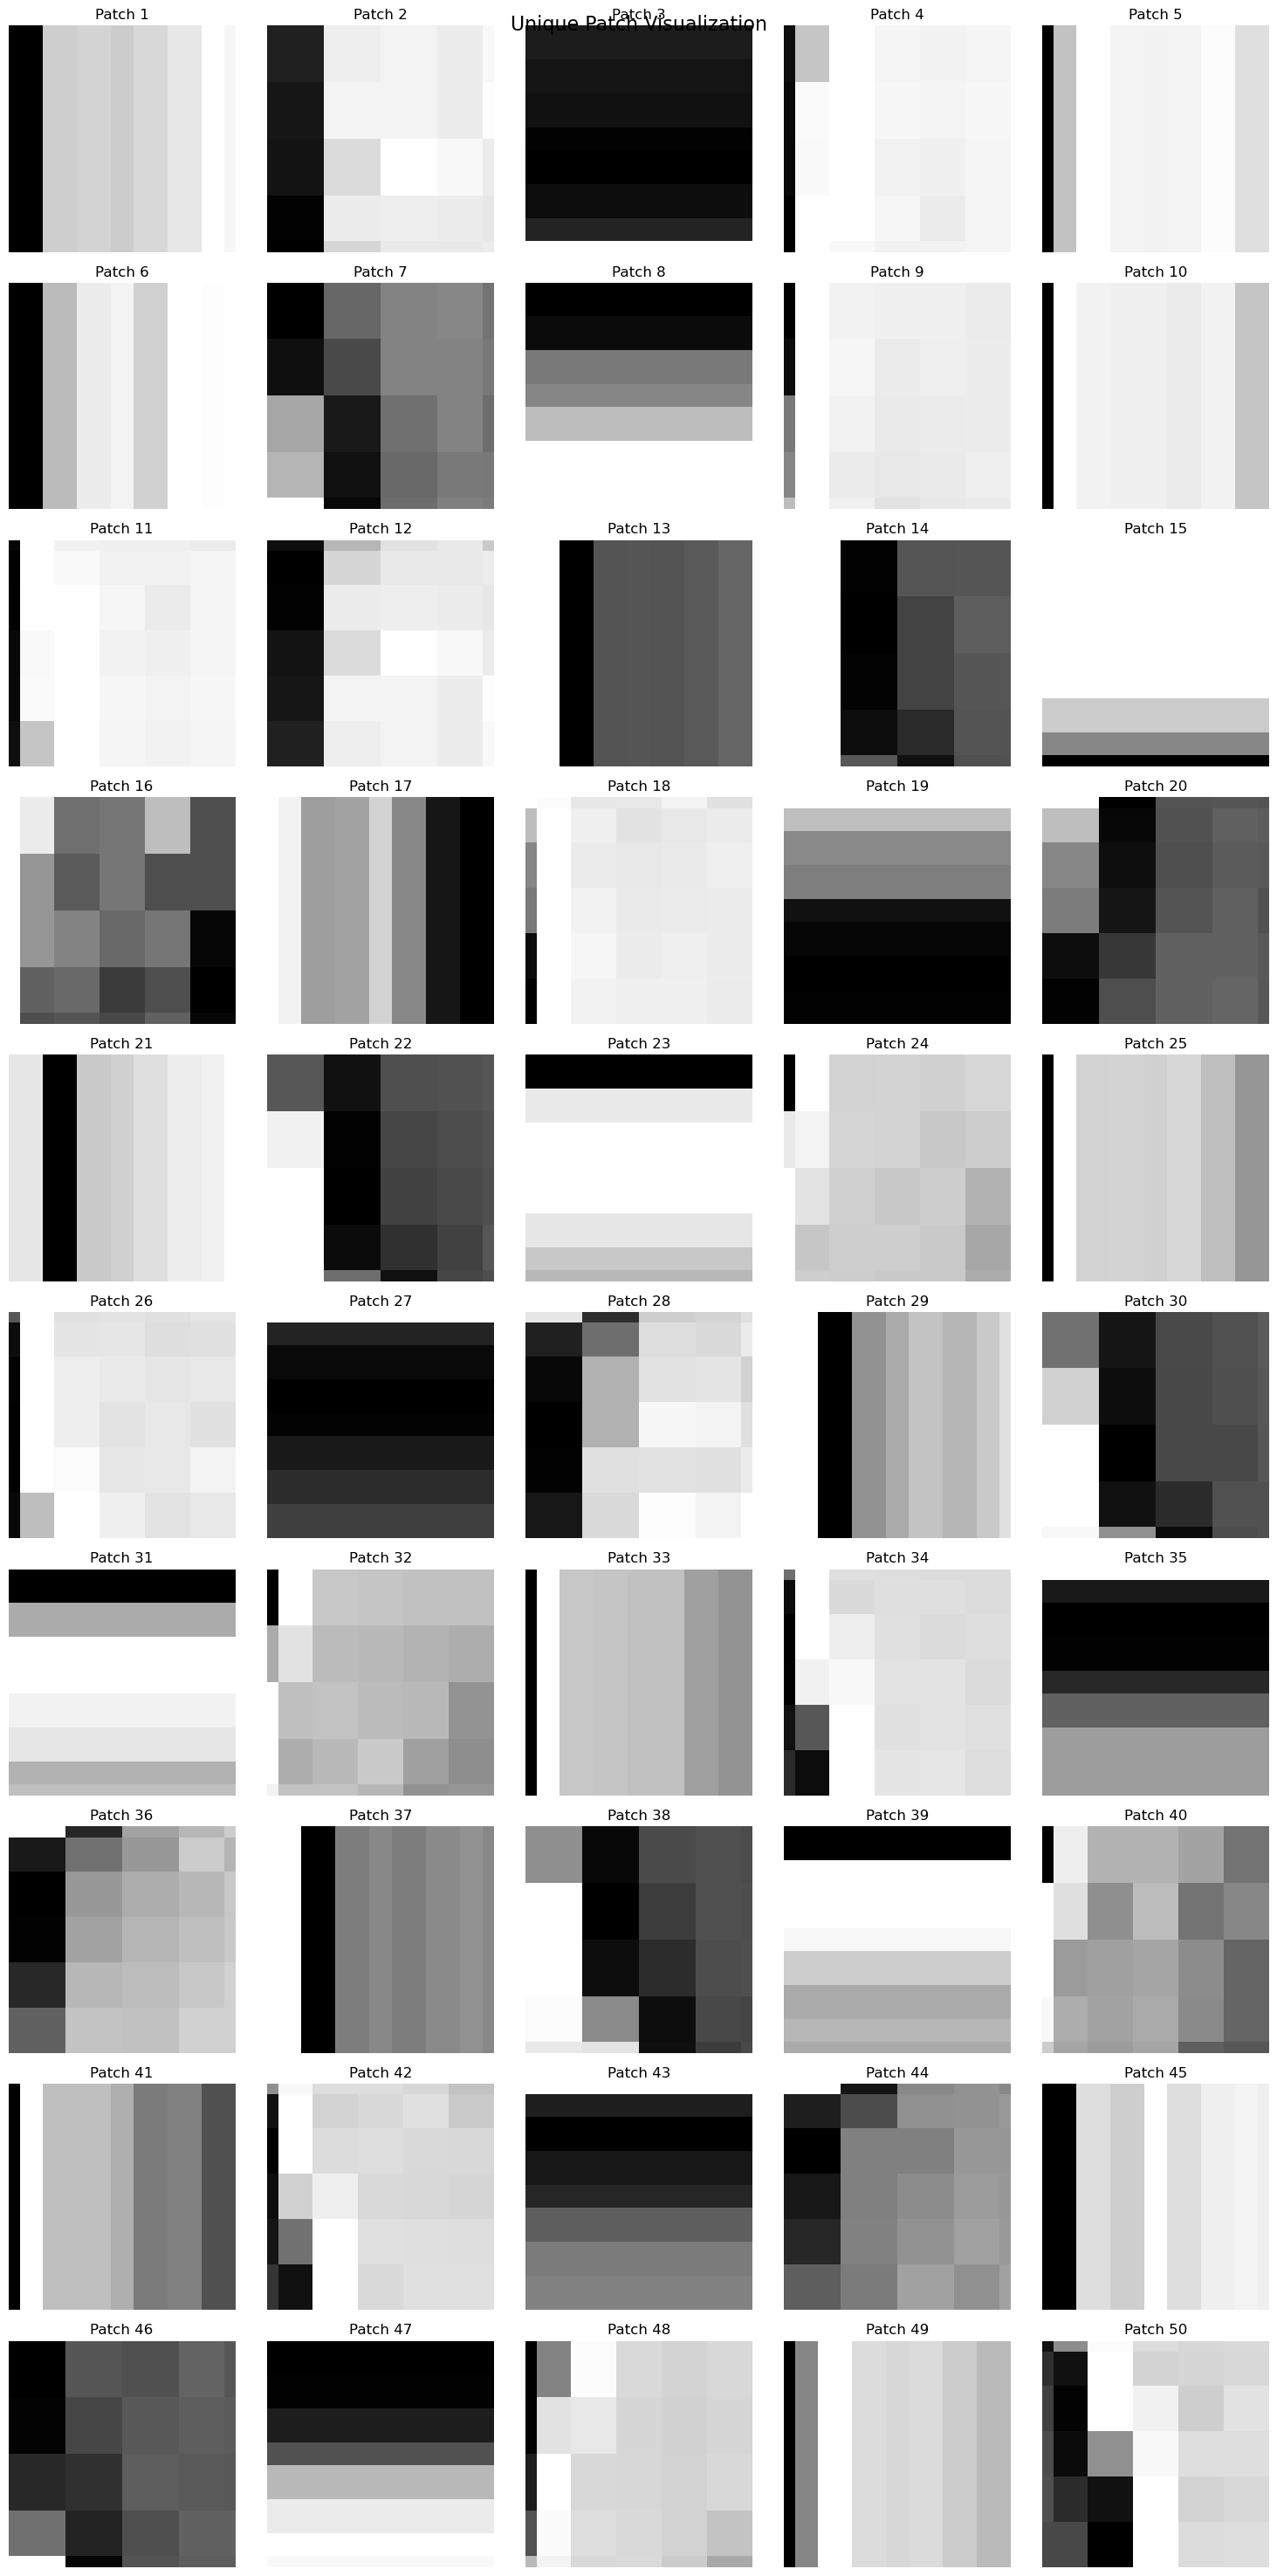

In [10]:
VisualizeUniquePatches(img, unique_lines, PatchSize=20, max_patches=50, title="Unique Patch Visualization")


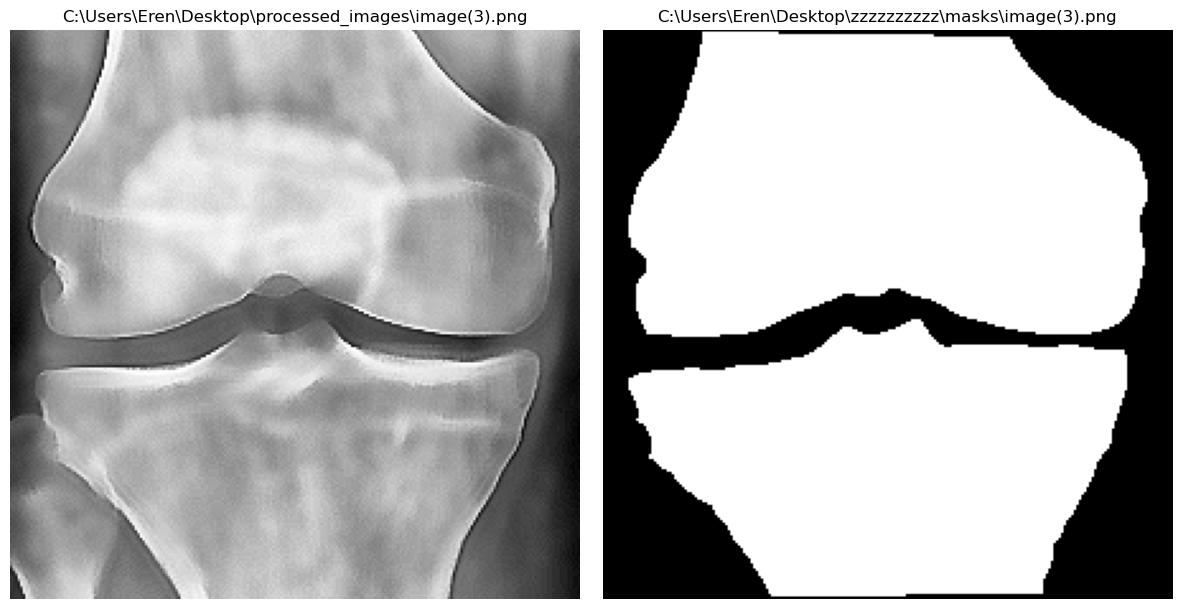

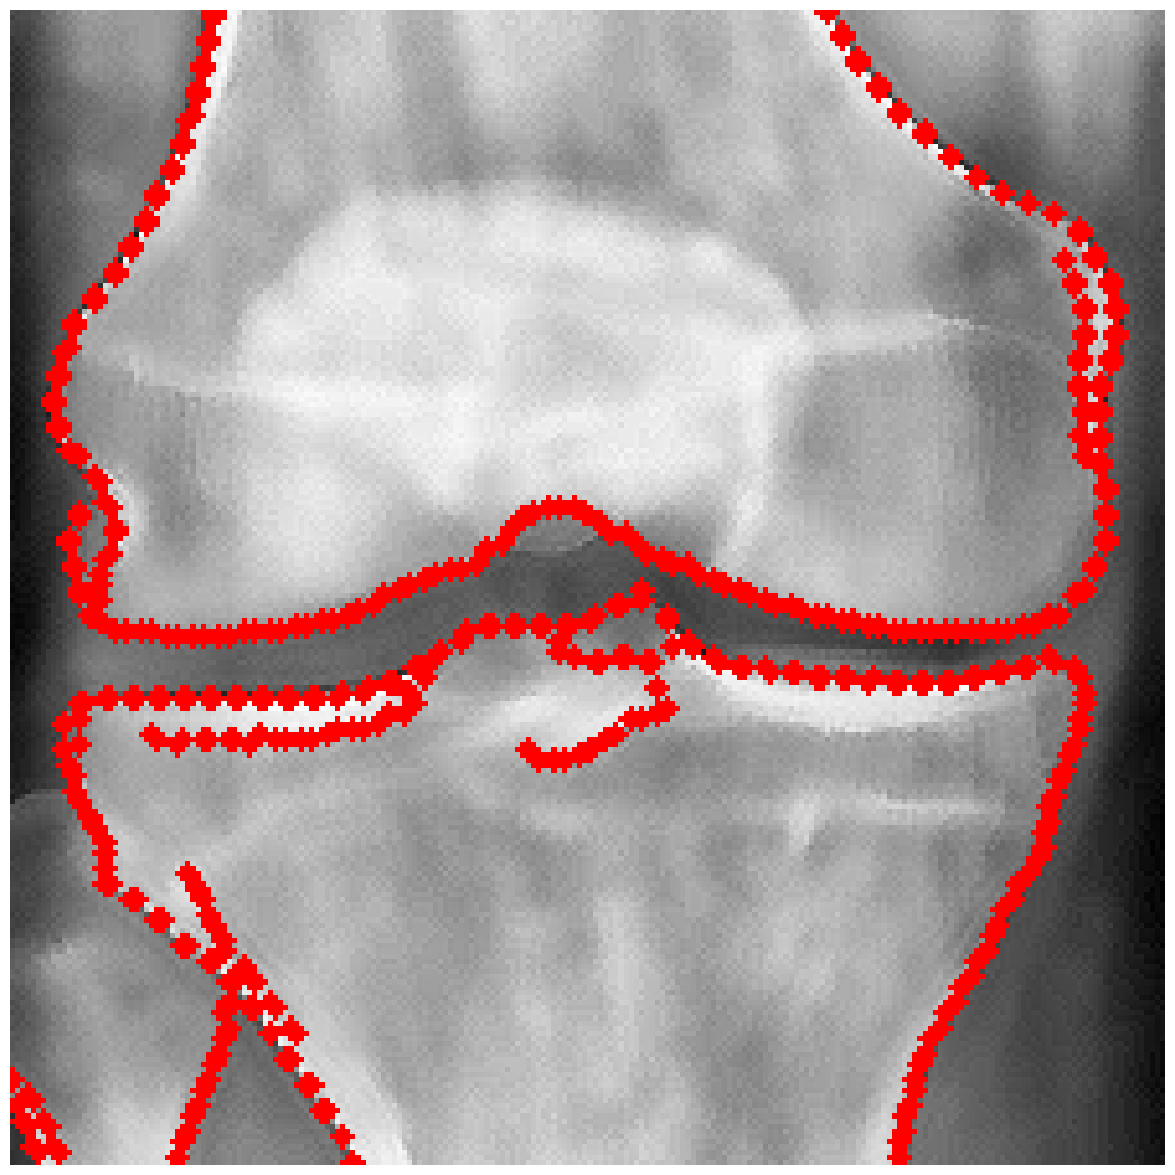

In [11]:
# 7. Test görüntüsünü yükle ve kenar noktalarını bul
test_img, test_label = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(3).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(3).png', draw=True)
test_EdgePoints = GetCannyEdgePoints(test_img, sparsity_factor=5, draw=True)

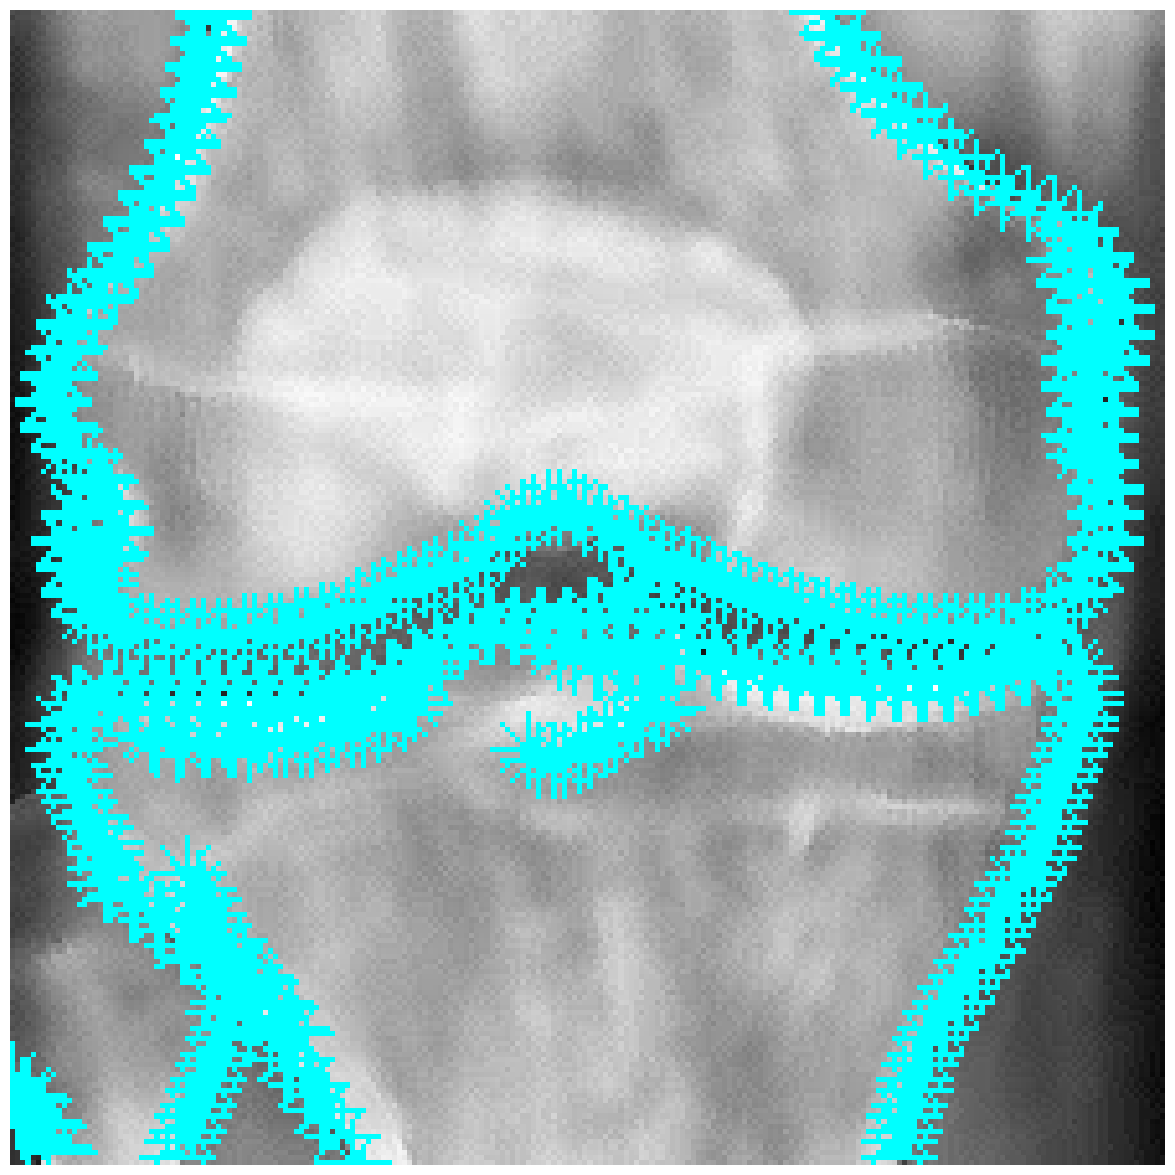

EdgeVecs boyutu: (3493, 72)


In [12]:
# 8. Test görüntüsünden çizgiler oluştur ve vektörleri al
test_EdgeLines = GetEdgeLines(test_img, test_EdgePoints, line_length=7, draw=True)
test_EdgeVecs = EdgeLines2EdgeVecs(test_EdgeLines, test_img, PatchSize=12, draw=True)


In [11]:
from sklearn.preprocessing import normalize

img_UniqueVecs = normalize(unique_vecs, axis=1)
test_img_EdgeVecs = normalize(test_EdgeVecs, axis=1)


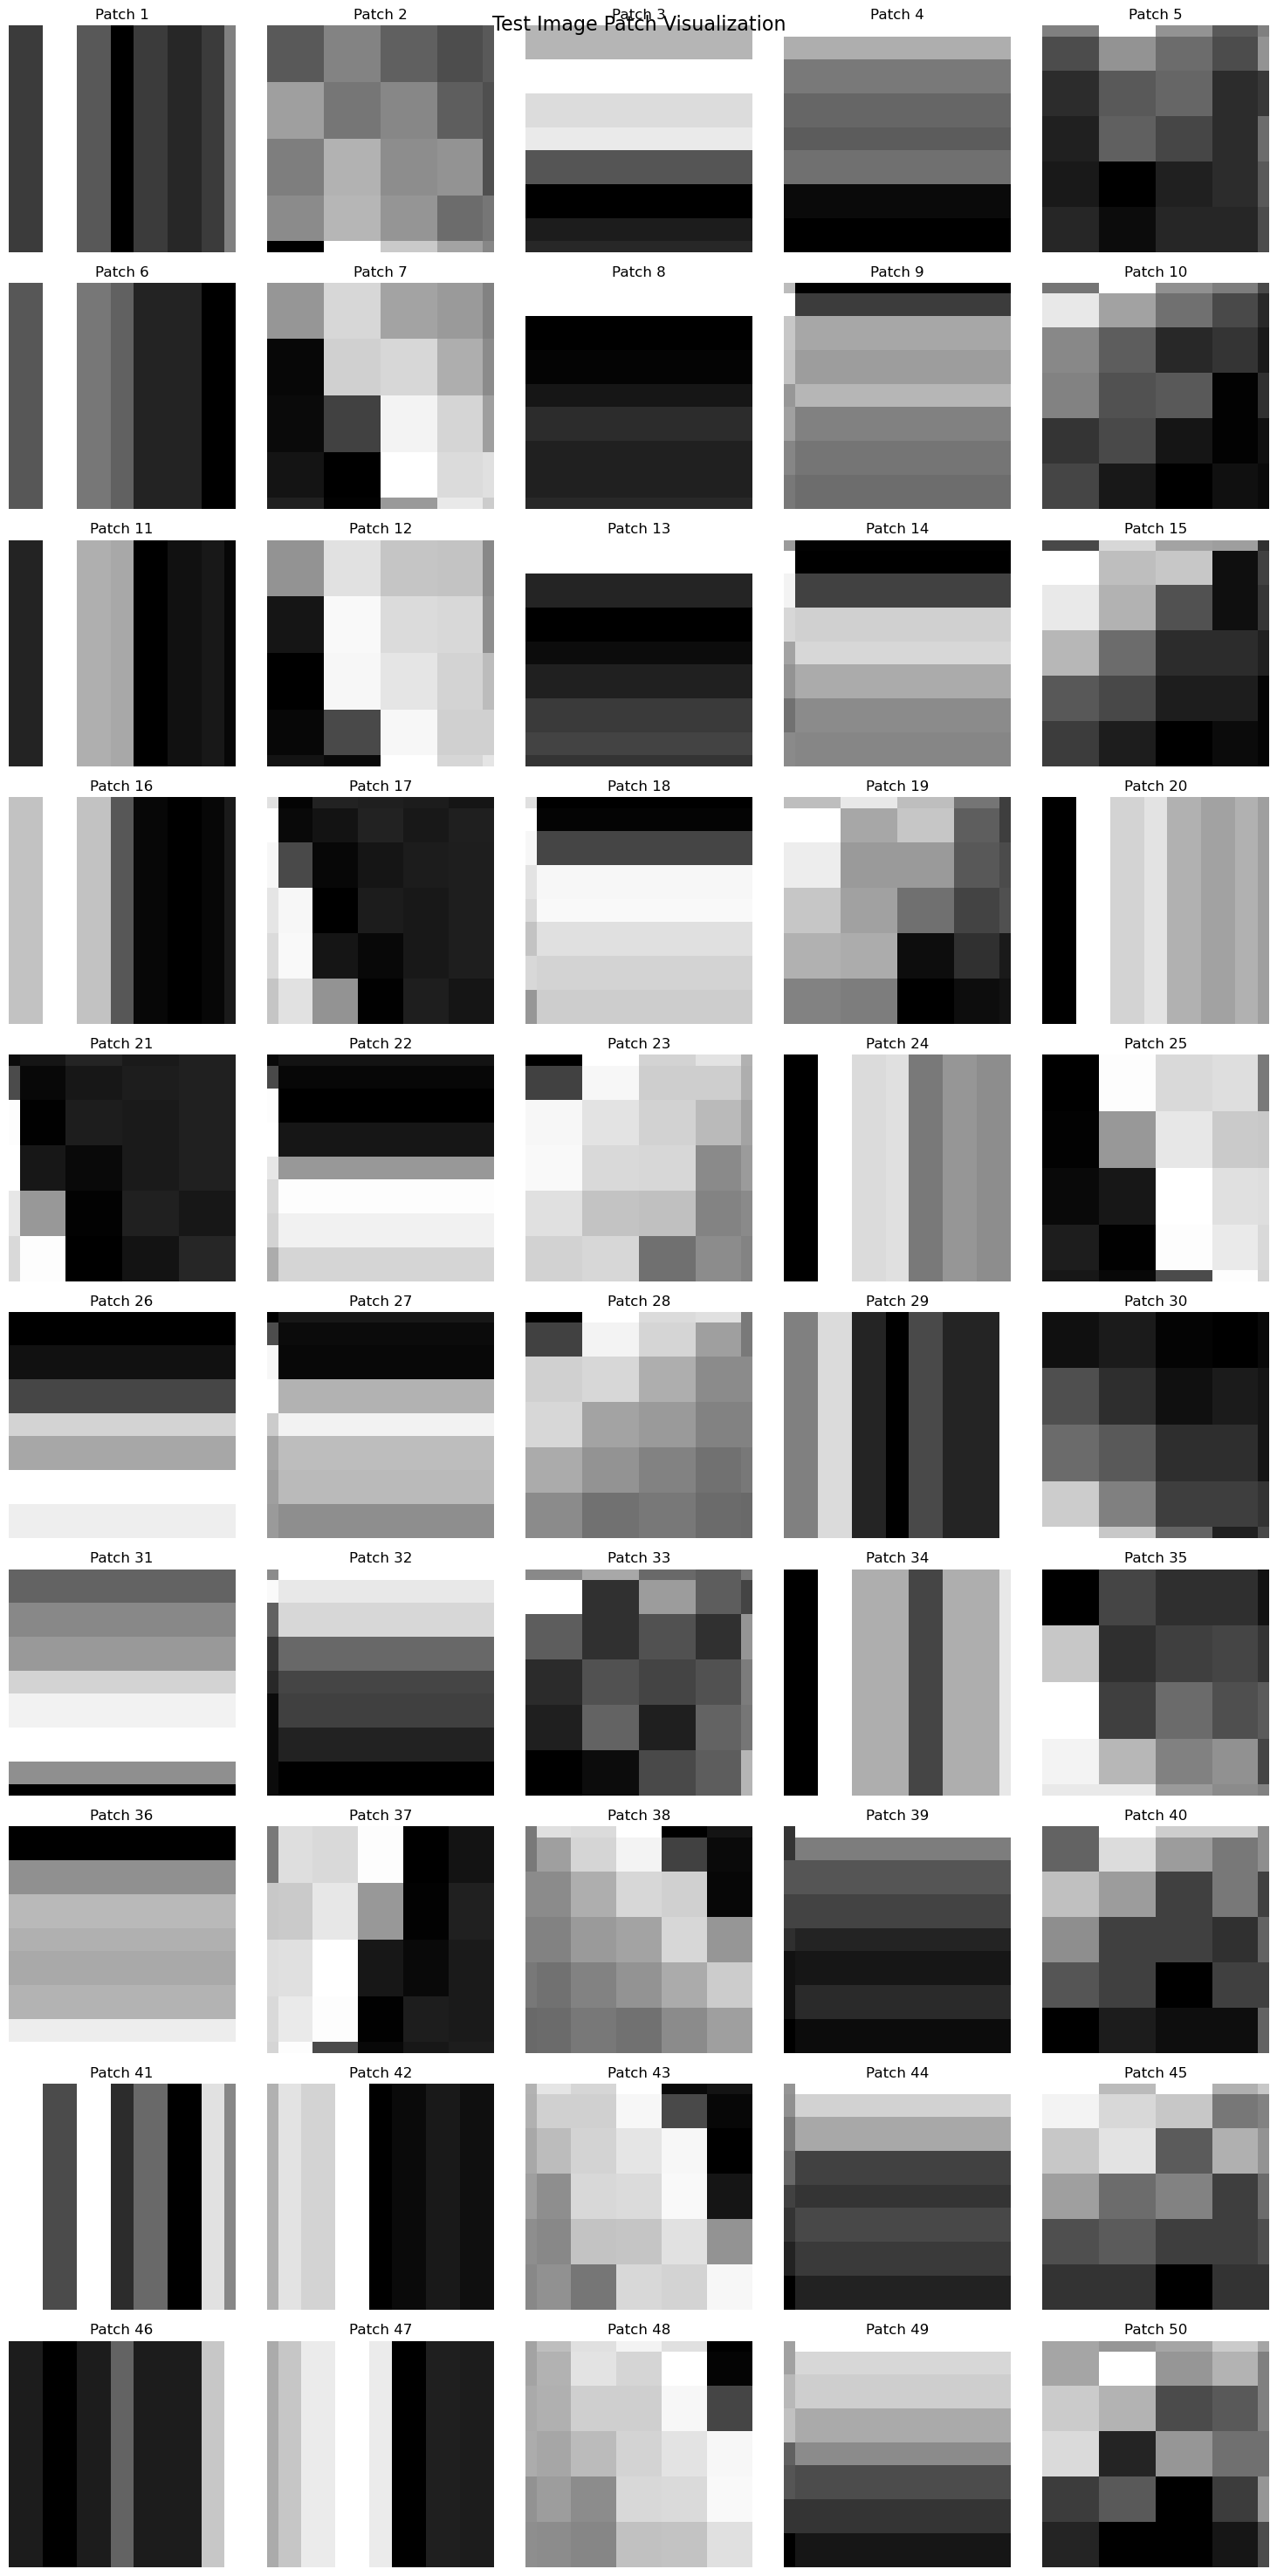

In [13]:
VisualizeUniquePatches(test_img, test_EdgeLines, PatchSize=20, max_patches=50, title="Test Image Patch Visualization")

1802 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\kenar_unique_vectors.pkl dosyasından yüklendi.
Eşleşen Noktalar: 303


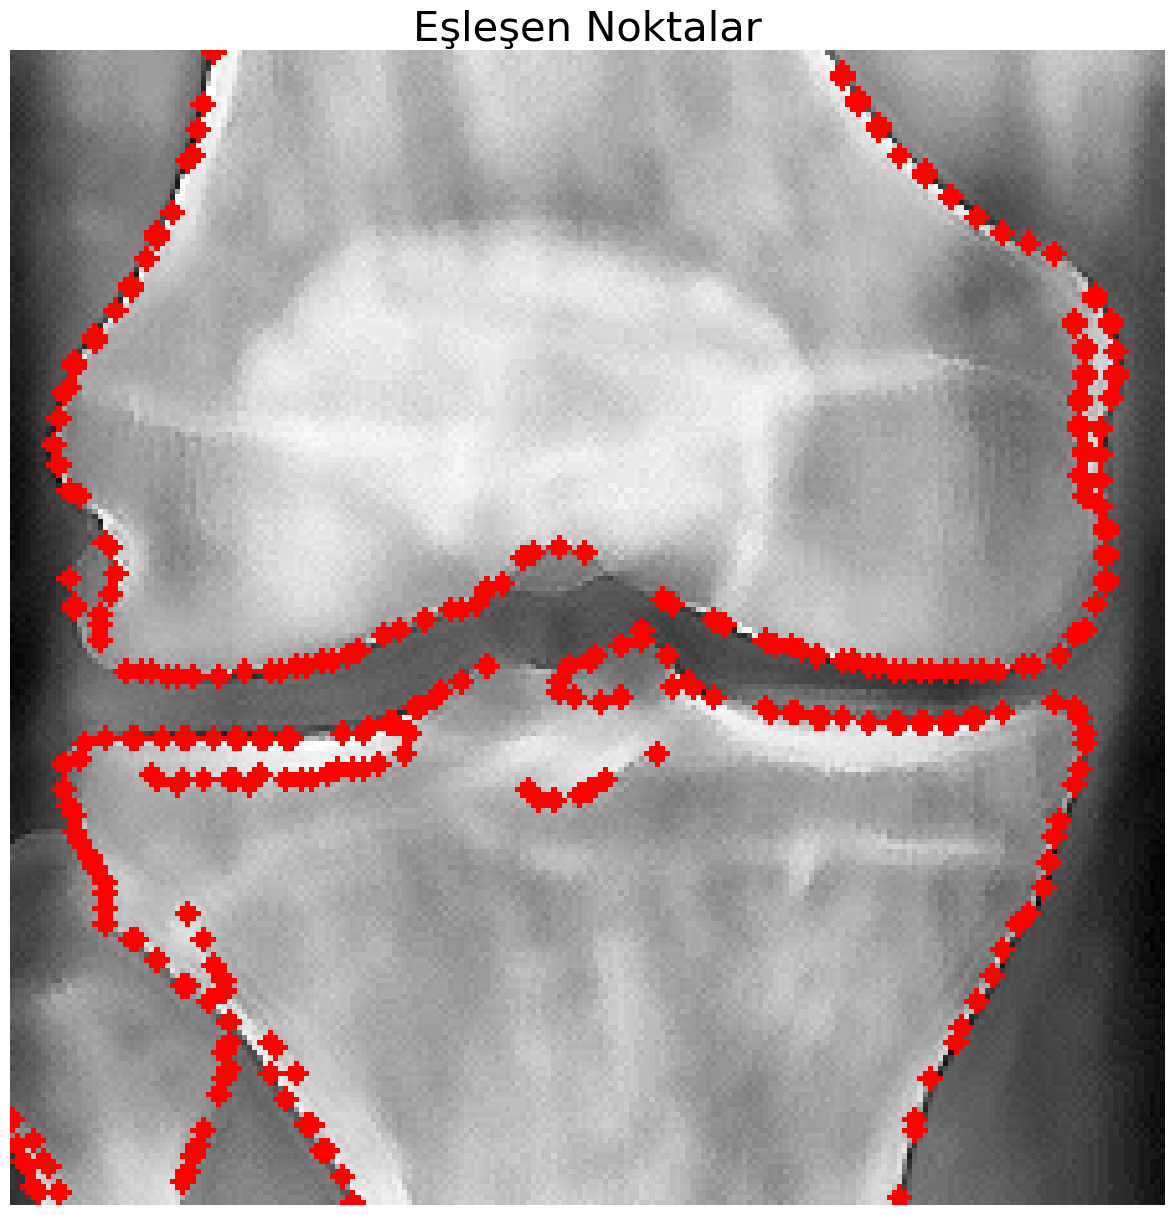

In [14]:
# 9. Test görüntüsündeki eşleşen çizgileri bul
uniquevector = LoadUniqueVectors(filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\kenar_unique_vectors.pkl")
TrueEdgePoints, TrueEdgeVecs = Match(uniquevector, test_EdgeVecs, test_EdgePoints, threshold=0.9998)
print(f"Eşleşen Noktalar: {len(TrueEdgePoints)}")
# Görselleştirme
Drawing(test_img, EdgePoints=TrueEdgePoints, title=f"Eşleşen Noktalar")

**Burda en uygun morfolojik işlemle test görselindeki kenarlar belirlendi**

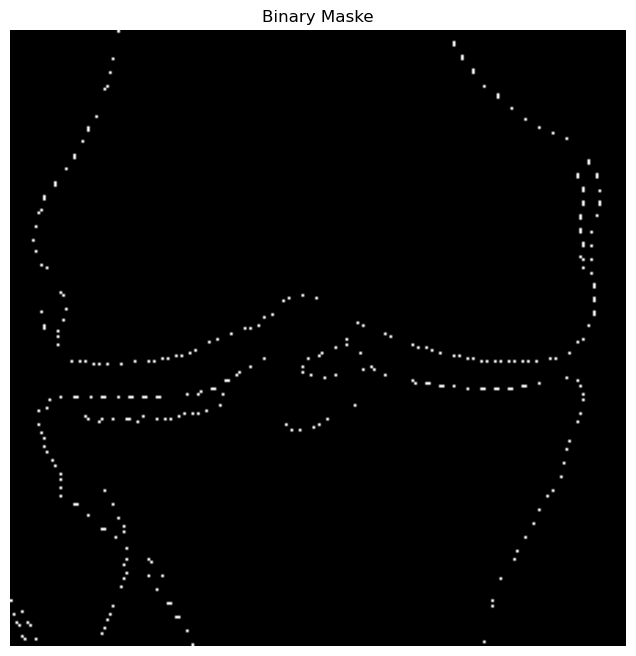

In [21]:
def create_binary_mask(img_shape, edge_points):
    """
    Kenar noktalarını (EdgePoints) kullanarak binary bir maske oluşturur.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y,x) formatındaki koordinat listesi.

    Returns:
    - mask: Binary maske (aynı boyutlarda, kenar noktaları 1, geri kalanı 0).
    """
    # Boş bir maske oluştur (0 değerleriyle)
    mask = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını maske üzerinde işaretle
    for y, x in edge_points:
        mask[y, x] = 255  # Noktaları beyaz yap

    return mask

test_image_shape = test_img.shape

TrueEdgePointss = TrueEdgePoints

binary_mask = create_binary_mask(test_image_shape, TrueEdgePointss)

plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Maske")
plt.axis('off')
plt.show()

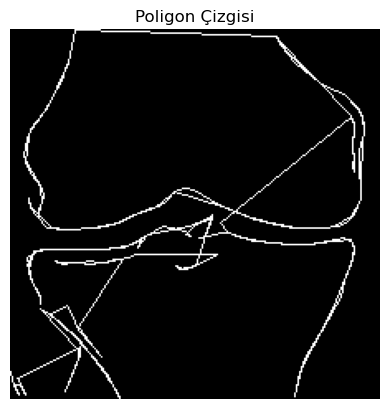

In [22]:
def draw_contour(img_shape, edge_points):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])
        cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img


contour_img = draw_contour(test_image_shape, TrueEdgePointss)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()

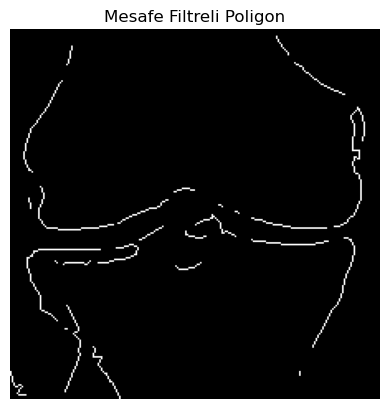

In [31]:
from scipy.spatial import distance

def sort_edge_points(edge_points):
    """
    Kenar noktalarını birbirine en yakın olacak şekilde sıralar.

    Args:
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.

    Returns:
    - sorted_points: Sıralanmış kenar noktaları.
    """
    sorted_points = [edge_points[0]]  # Başlangıç noktası
    remaining_points = edge_points[1:]

    while remaining_points:
        last_point = sorted_points[-1]
        # Kalan noktalar arasından en yakın olanı seç
        closest_point = min(remaining_points, key=lambda p: distance.euclidean(last_point, p))
        sorted_points.append(closest_point)
        remaining_points.remove(closest_point)

    return sorted_points
sorted_points = sort_edge_points(TrueEdgePoints)
contour_img = draw_contour(test_image_shape, sorted_points)

def draw_contour_with_distance_filter(img_shape, edge_points, max_distance=20):
    """
    Kenar noktalarını birleştirirken mesafe filtresi uygular.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: İki nokta arasındaki maksimum mesafe (piksel).

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y)
        end_point = tuple(edge_points[i + 1][::-1])
        # İki nokta arasındaki mesafeyi kontrol et
        if distance.euclidean(edge_points[i], edge_points[i + 1]) <= max_distance:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

contour_img = draw_contour_with_distance_filter(test_image_shape, sorted_points, max_distance=8)
plt.imshow(contour_img, cmap='gray')
plt.title("Mesafe Filtreli Poligon")
plt.axis('off')
plt.show()


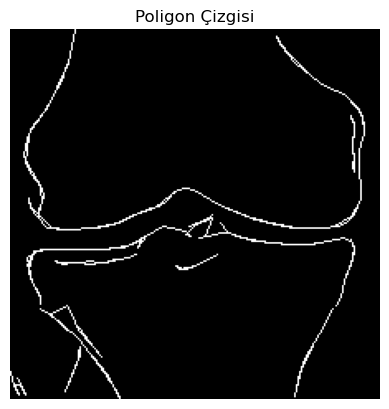

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse çizgi çiz
        if distance <= max_distance:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

# Örnek kullanım
# Örnek veri (test_label_shape ve testlabel_EdgePoints'i kullanıcı sağlamalı)
# test_label_shape = (512, 512)
# testlabel_EdgePoints = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 100

contour_img = draw_contour(test_image_shape, TrueEdgePointss, max_distance=20)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()


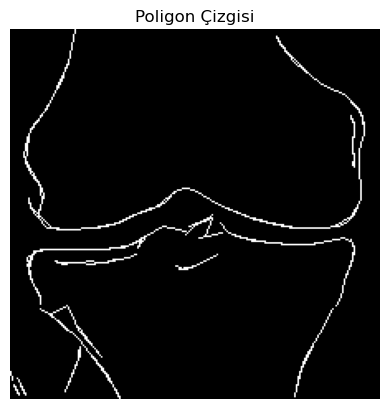

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance, min_line_length):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez
    ve belirli bir uzunluktan kısa olan çizgileri çizmez.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.
    - min_line_length: Çizilecek minimum çizgi uzunluğu.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse ve çizgi uzunluğu yeterliyse çizgi çiz
        if distance <= max_distance and distance >= min_line_length:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

# Örnek kullanım
# Örnek veri (test_image_shape ve TrueEdgePointss'i kullanıcı sağlamalı)
# test_image_shape = (512, 512)
# TrueEdgePointss = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 100
# min_line_length = 10

contour_img = draw_contour(test_image_shape, TrueEdgePointss, max_distance=20, min_line_length=5)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()


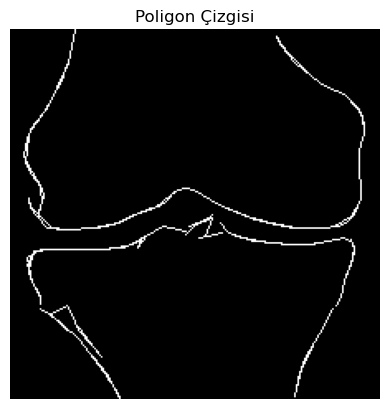

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance, min_line_length, min_component_size):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez,
    belirli bir uzunluktan kısa olan çizgileri çizmez ve küçük ayrık bileşenleri saf dışı bırakır.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.
    - min_line_length: Çizilecek minimum çizgi uzunluğu.
    - min_component_size: Görüntüde kalmasına izin verilen minimum bileşen boyutu (piksel sayısı).

    Returns:
    - contour_img: Kenar çizgileri çizilmiş ve küçük bileşenler kaldırılmış bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse ve çizgi uzunluğu yeterliyse çizgi çiz
        if distance <= max_distance and distance >= min_line_length:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    # Bağlı bileşen analizi ile küçük bileşenleri kaldır
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(contour_img, connectivity=8)

    # Yeni bir görüntü oluştur ve sadece büyük bileşenleri ekle
    filtered_img = np.zeros_like(contour_img)
    for i in range(1, num_labels):  # 0 etiket arka plan olduğu için atlanır
        if stats[i, cv2.CC_STAT_AREA] >= min_component_size:
            filtered_img[labels == i] = 255

    return filtered_img

# Örnek kullanım
# Örnek veri (test_image_shape ve TrueEdgePointss'i kullanıcı sağlamalı)
# test_image_shape = (512, 512)
# TrueEdgePointss = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 20
# min_line_length = 10
# min_component_size = 50  # Minimum bileşen boyutu (piksel sayısı)

contour_img = draw_contour(test_image_shape, TrueEdgePointss, max_distance=20, min_line_length=5, min_component_size=65)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()


**IoU için test görselinin labelinden kenarlar bulundu**

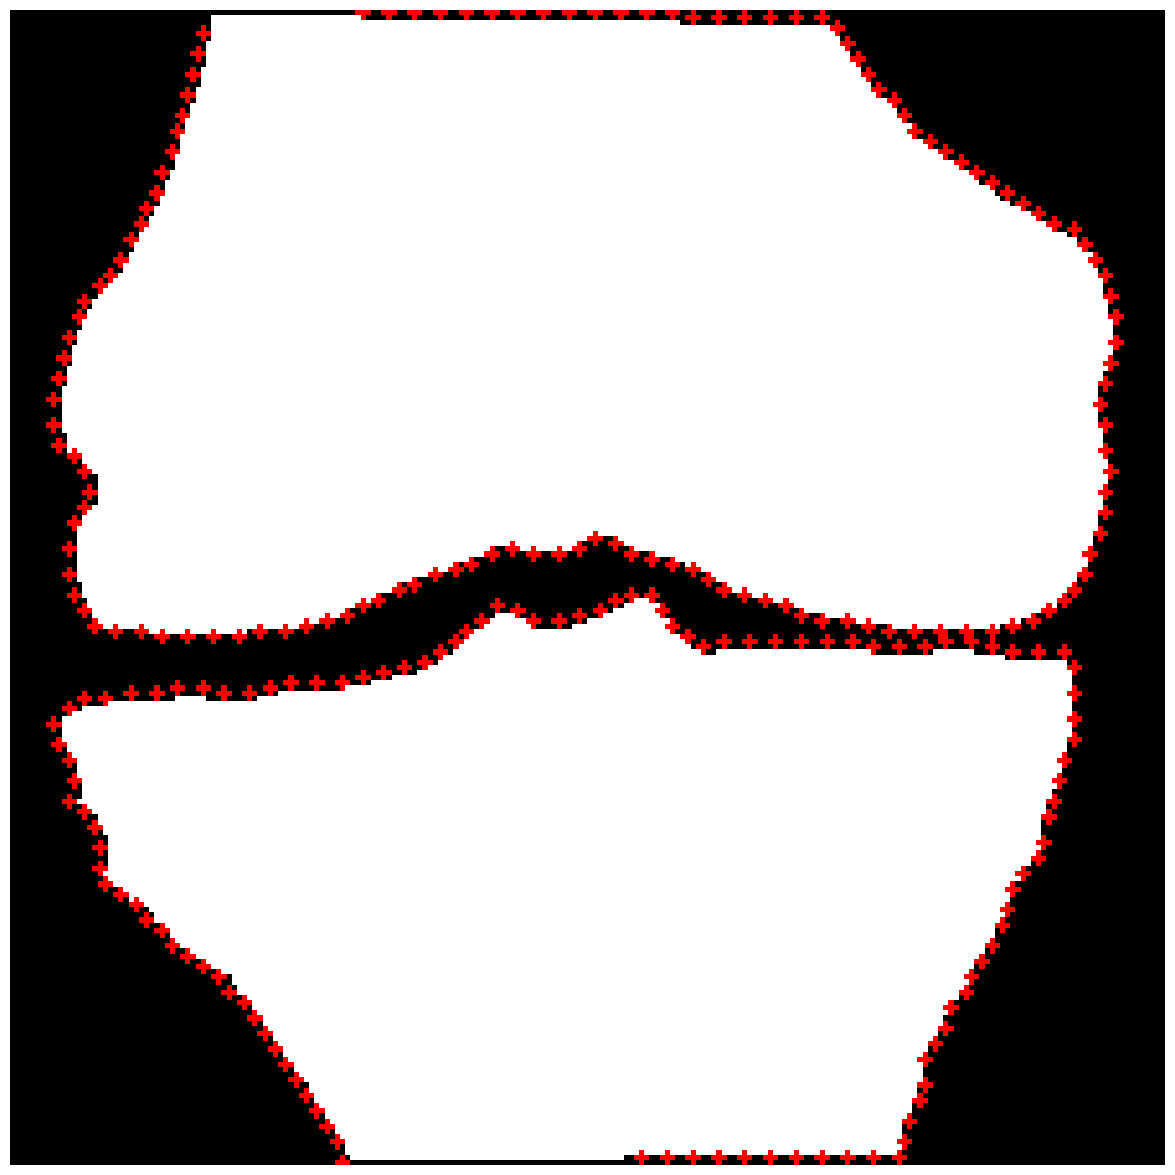

In [ ]:

testlabel_EdgePoints = GetLabelEdgePoints(test_label, sparsity_factor=5, draw=True)

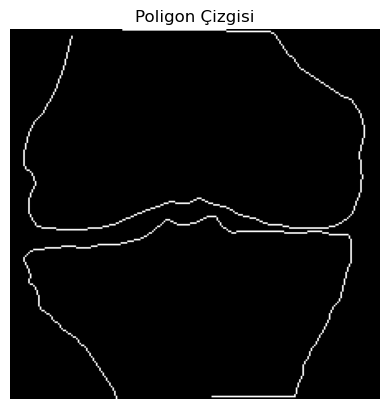

In [59]:
test_label_shape = test_label.shape

import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse çizgi çiz
        if distance <= max_distance:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

# Örnek kullanım
# Örnek veri (test_label_shape ve testlabel_EdgePoints'i kullanıcı sağlamalı)
# test_label_shape = (512, 512)
# testlabel_EdgePoints = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 100

contour_label = draw_contour(test_label_shape, testlabel_EdgePoints, max_distance=50)
plt.imshow(contour_label, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()


IoU: 0.1859


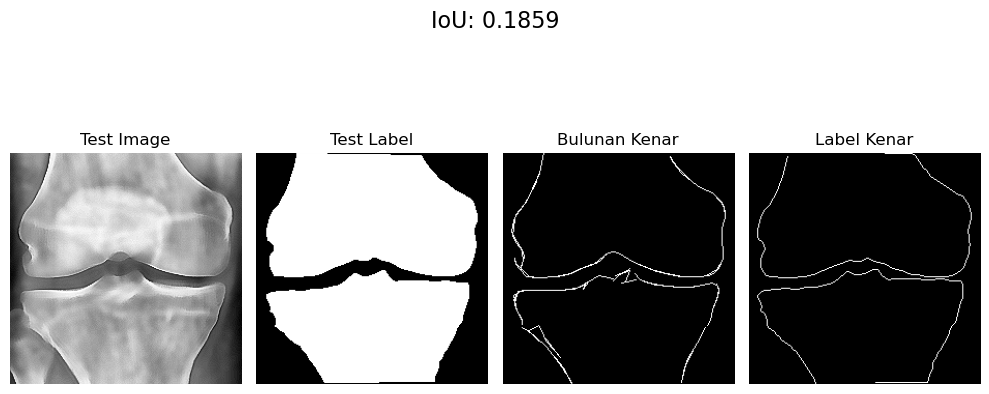

In [83]:
import numpy as np

def calculate_iou(binary_image1, binary_image2):
    """
    İki binary görüntü arasındaki Intersection over Union (IoU) değerini hesaplar.

    Args:
    - binary_image1: İlk binary görüntü (numpy array).
    - binary_image2: İkinci binary görüntü (numpy array).

    Returns:
    - IoU: İki görüntü arasındaki IoU değeri.
    """
    # Kesişim ve birleşim hesaplama
    intersection = np.logical_and(binary_image1, binary_image2).sum()
    union = np.logical_or(binary_image1, binary_image2).sum()

    # IoU hesaplama
    if union == 0:
        return 0  # Birleşim sıfırsa IoU tanımsızdır, bu nedenle 0 döndürüyoruz.
    iou = intersection / union
    return iou

# Örnek kullanım
# binary_image1 ve binary_image2'nin aynı boyutta olduğunu varsayıyoruz
# binary_image1 = np.array(...)  # İlk binary görüntü
# binary_image2 = np.array(...)  # İkinci binary görüntü

iou_value = calculate_iou(contour_img, contour_label)
print(f"IoU: {iou_value:.4f}")

# Görselleştirme
plt.figure(figsize=(10, 5))
# IoU başlığı
plt.suptitle(f"IoU: {iou_value:.4f}", fontsize=16)

# Bulunan kontur görüntüsü
plt.subplot(1, 4, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 2)
plt.imshow(test_label, cmap='gray')
plt.title("Test Label")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(contour_img, cmap='gray')
plt.title("Bulunan Kenar")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 4)
plt.imshow(contour_label, cmap='gray')
plt.title("Label Kenar")
plt.axis('off')

plt.tight_layout()
plt.show()

**(2.MADDE)Her bir kenar noktasından mxm boyutlu patch alınarak kodlandı ve test görüntüsü ile karşılaştırıldı bulunan sonuca binary mask ve morfolojik işlemler uygulanarak kenar tespit edildi.**

In [72]:
!pip install kymatio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from kymatio import Scattering2D
from skimage import measure
import pickle
import os


# Benzersiz vektörleri bir dosyaya kaydetmek için fonksiyon
def SaveUniqueVectors(vectors, filename="unique_vectors.pkl"):
    """
    Benzersiz vektörleri bir dosyaya kaydeder. Dosya yoksa oluşturur.

    Parameters:
    - vectors: Kaydedilecek vektörler (numpy array)
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)
    """
    if not os.path.exists(filename):
        print(f"{filename} oluşturuluyor...")

    with open(filename, "wb") as f:
        pickle.dump(vectors, f)
    print(f"{len(vectors)} vektör {filename} dosyasına kaydedildi.")


# Benzersiz vektörleri bir dosyadan yüklemek için fonksiyon
def LoadUniqueVectors(filename="unique_vectors.pkl"):
    """
    Dosyadan benzersiz vektörleri yükler.

    Parameters:
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)

    Returns:
    - vectors: Yüklenen vektörler (numpy array)
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Dosya bulunamadı: {filename}")

    with open(filename, "rb") as f:
        vectors = pickle.load(f)
    print(f"{len(vectors)} vektör {filename} dosyasından yüklendi.")
    return vectors



def GetImageLabel(imgStr,labelStr,draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img) # print(img.max())

    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)
   

    if draw:
        # Görüntü ve etiketleri yan yana çiz
        plt.figure(figsize=(12, 6))  # Şekil boyutunu ayarla
        plt.subplot(1, 2, 1)  # 1 satır, 2 sütun, ilk eksen
        plt.imshow(img, cmap='gray')  # img görüntüsünü göster
        plt.title(imgStr)  # Başlık
        plt.axis('off')  # Eksenleri kapat

        plt.subplot(1, 2, 2)  # 1 satır, 2 sütun, ikinci eksen
        plt.imshow(label, cmap='gray')  # label görüntüsünü göster
        plt.title(labelStr)  # Başlık
        plt.axis('off')  # Eksenleri kapat

        plt.tight_layout()
        plt.show()  # Şekli göster
    return img, label

def ConvertAndNormalize(img):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Görüntüyü normalize et (0-255 aralığına getir)
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    return normalized_img

def Drawing(img, EdgePoints=None, EdgeLines=None, EdgePatchs=None, title=None, circle_radius = 2):
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if EdgePoints is not None:
        for point in EdgePoints:
            x, y = int(point[1]), int(point[0])  # x ve y koordinatları ters çevrilir
            cv2.circle(output_img, (x, y), circle_radius, (0, 0, 255), -1)  # Kırmızı daire

    if EdgeLines is not None:
        for Line in EdgeLines:
            start_point = Line["StartPointYX"]
            stop_point = Line["StopPointYX"]
            cv2.line(output_img, start_point[::-1], stop_point[::-1], color = (255, 255, 0) , thickness = 2)

    if EdgePatchs is not None:
        # Img uzerine Patch ciz
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 0, 0)
        thickness = 2
        for k, (x,y,PatchSize,angle) in enumerate(EdgePatchs):
            rect = cv2.boxPoints(((float(x), float(y)), (PatchSize, PatchSize), angle))
            rect = np.intp(rect)
            cv2.drawContours(output_img, [rect], 0, (0, 0, 255), 2)

            # Draw a line indicating the angle
            end_x = int(x + (PatchSize / 2) * np.cos(np.radians(angle)))
            end_y = int(y + (PatchSize / 2) * np.sin(np.radians(angle)))
            cv2.line(output_img, (x, y), (end_x, end_y), (0, 0, 255), 2)
            cv2.putText(output_img, str(k), (x, y - 10), font, font_scale, color, thickness, cv2.LINE_AA)

    # Görüntü boyutlarına göre figsize hesaplama
    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (15 * aspect_ratio, 15)  # Oranı koruyarak uygun bir ölçekleme

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()

def GetLabelEdgePoints(img, sparsity_factor=1, circle_radius = 10, draw=False):
    contours = measure.find_contours(img, level=0.5)
    # Tüm sınır piksellerini birleştir
    boundary_points = np.vstack(contours)

    # Sparsity factor ile seyrekleştirme
    if sparsity_factor > 1:
        boundary_points = boundary_points[::sparsity_factor]

    if draw:
        Drawing(img, EdgePoints=boundary_points, circle_radius=circle_radius)

    return boundary_points.astype(int)

def GetCannyEdgePoints(img, sparsity_factor=1, draw=False):
    blurimg = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurimg, 40, 190)
    CannyEdgePoints, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    EdgePoints = []
    for ObjPoints in CannyEdgePoints:
        EdgePoints = EdgePoints + [(point[0][1], point[0][0]) for i, point in enumerate(ObjPoints) if i % sparsity_factor == 0]

    if draw:
        Drawing(img, EdgePoints=EdgePoints)

    return EdgePoints

def EuclidDistance(point1,point2):
    y1,x1 = point1
    y2,x2 = point2
    return int(np.sqrt((x1-x2)**2 + (y1-y2)**2))

def GetEdgePatchs(img, EdgePoints, PatchSize=11, draw=True):
    EdgePatchs = []
    EdgePatchsInfo = []
    for i in range(len(EdgePoints)):
        # Çizginin başlangıç noktası
        y, x = EdgePoints[i]

        # Çizginin yönü
        prev_idx = (i - 1) % len(EdgePoints)
        next_idx = (i + 1) % len(EdgePoints)
        y1, x1 = EdgePoints[prev_idx]
        y2, x2 = EdgePoints[next_idx]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.atan2(-dx, dy)

        # Patch al
        center = (float(x), float(y))
        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(angle), scale=1.0)
        rows, cols = img.shape
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        # Patch sınırlarını kontrol et
        y_start, y_end = y - PatchSize, y + PatchSize + 1
        x_start, x_end = x - PatchSize, x + PatchSize + 1

        if y_start < 0 or y_end > rows or x_start < 0 or x_end > cols:
            # Patch görüntü sınırlarının dışında, atla
            continue

        EdgePatch = rotated_image[y-PatchSize:y+PatchSize+1, x-PatchSize:x+PatchSize+1]

        EdgePatchs.append(EdgePatch)
        EdgePatchsInfo.append([x,y,PatchSize,np.degrees(angle)])

    if draw:
        Drawing(img, EdgePoints=EdgePoints, EdgePatchs = EdgePatchsInfo)

    return EdgePatchs, EdgePatchsInfo

def DisplayPatches(EdgePatchs, max_cols=10):
    # Toplam patch sayısı
    num_patches = len(EdgePatchs)

    # Sütun sayısı (max_cols ile sınırlı)
    cols = min(max_cols, num_patches)

    # Satır sayısını hesapla
    rows = math.ceil(num_patches / cols)

    # Şekil oluşturma
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(-1)  # Tek boyutlu diziye dönüştür

    for i, ax in enumerate(axes):
        if i < num_patches:
            ax.imshow(EdgePatchs[i], cmap='gray')
            ax.text(5, 10, str(i), color='red', fontsize=18, ha='left', va='top')
            ax.axis('off')
        else:
            ax.axis('off')  # Fazla eksenleri kapat

    plt.tight_layout()
    plt.show()

def GetWSN(J,PatchSize):
    S = Scattering2D(J=J, shape=(PatchSize, PatchSize), L=2, max_order=2, frontend='numpy')
    return S

def EdgePatchs2EdgeVecs(EdgePatchs,draw = False):
    # EdgePatchs --> EdgeVecs
    PatchSize = len(EdgePatchs[0])

    S = GetWSN(J=4,PatchSize=PatchSize) # Scattering Network

    EdgeVecs = []
    for img in EdgePatchs:
        img = img.astype(np.float32)
        coeffs = S(img)                                 # (33, 6, 6)
        vec = coeffs.mean(axis=(1, 2)).reshape(-1, 1)   # (33, 1)
        EdgeVecs.append(vec)
    EdgeVecs = np.squeeze(np.array(EdgeVecs))

    if draw:
        print("EdgeVecs boyutu:",EdgeVecs.shape)

    return EdgeVecs

def FindUniqueVectors(vectors, threshold=10):
    unique_indices = []
    for i, vector in enumerate(vectors):
        is_unique = True
        for j in unique_indices:
            if np.linalg.norm(vector - vectors[j]) < threshold:
                is_unique = False
                break
        if is_unique:
            unique_indices.append(i)
    return unique_indices

def GetUniquePatchsVectors(EdgePatchs, EdgeVecs, UniqueInds, draw=False):
    Patchs = []
    Vectors = []
    for idx in UniqueInds:
            Patchs.append(EdgePatchs[idx])
            Vectors.append(EdgeVecs[idx])
    Vectors = np.squeeze(np.array(Vectors))
    if draw:
        DisplayPatches(Patchs)
        print("Vectors Size:", Vectors.shape)

    return Patchs, Vectors

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def Match(img_UniqueVecs, test_img_EdgeVecs, test_img_EdgePoints, threshold=5):
    TrueEdgePoints = []
    for i, test_vec in enumerate(test_img_EdgeVecs):
        similarities = [np.linalg.norm(test_vec - unique_vec) for unique_vec in img_UniqueVecs]
        #similarities = [cosine_similarity(test_vec - unique_vec) for unique_vec in img_UniqueVecs]
        if max(similarities) >= threshold:
            TrueEdgePoints.append(test_img_EdgePoints[i])

    return TrueEdgePoints

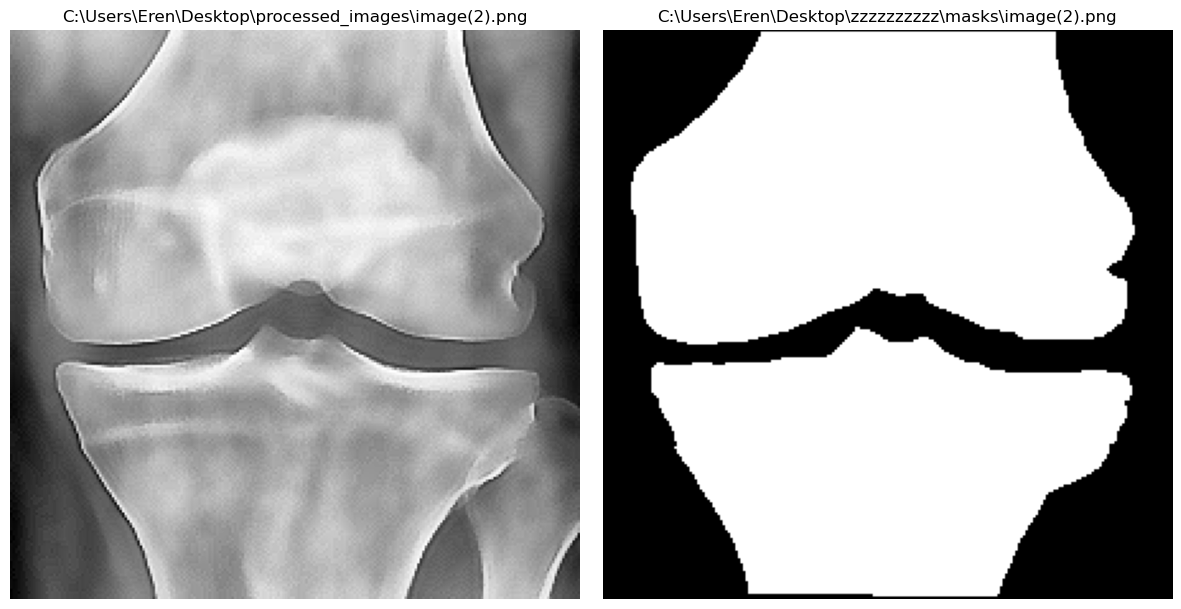

In [73]:
# img ve label gorselleri al
img, label = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(2).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(2).png',draw=True)

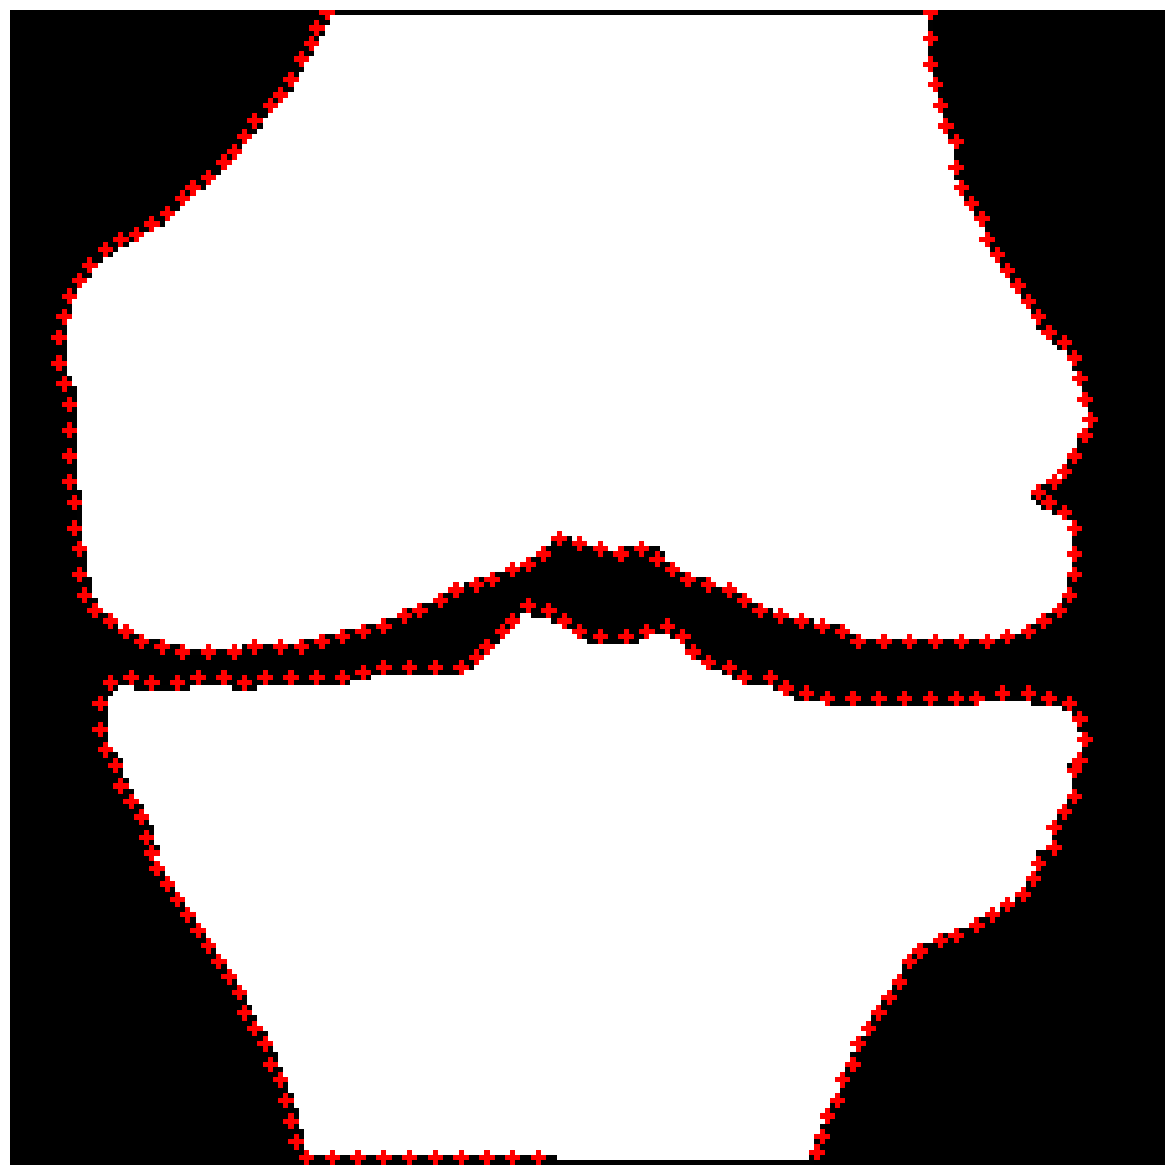

In [74]:
# Kenar Gorsellerinia Kodla
img_EdgePoints = GetLabelEdgePoints(label, sparsity_factor=5, circle_radius=1, draw=True)   # EdgePoints --> [p,2] --> (y,x)

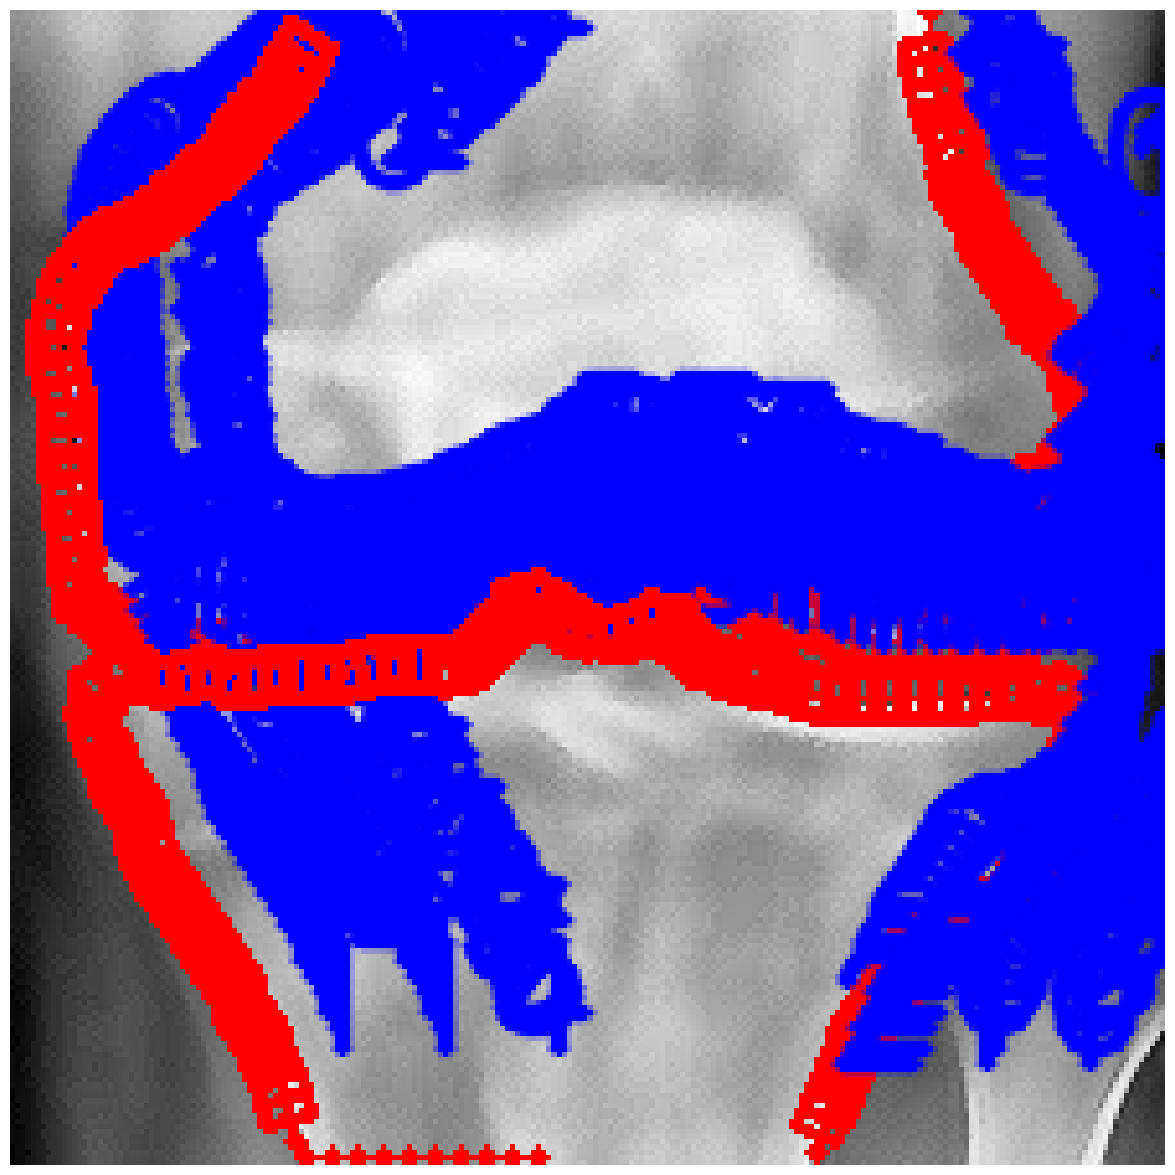

In [75]:
# img_EdgePoints --> img_EdgePatchs
img_EdgePatchs, img_EdgePatchsInfo = GetEdgePatchs(img, img_EdgePoints, PatchSize=9, draw=True)  # M = 2*PatchSize + 1,  MxM = 101x101

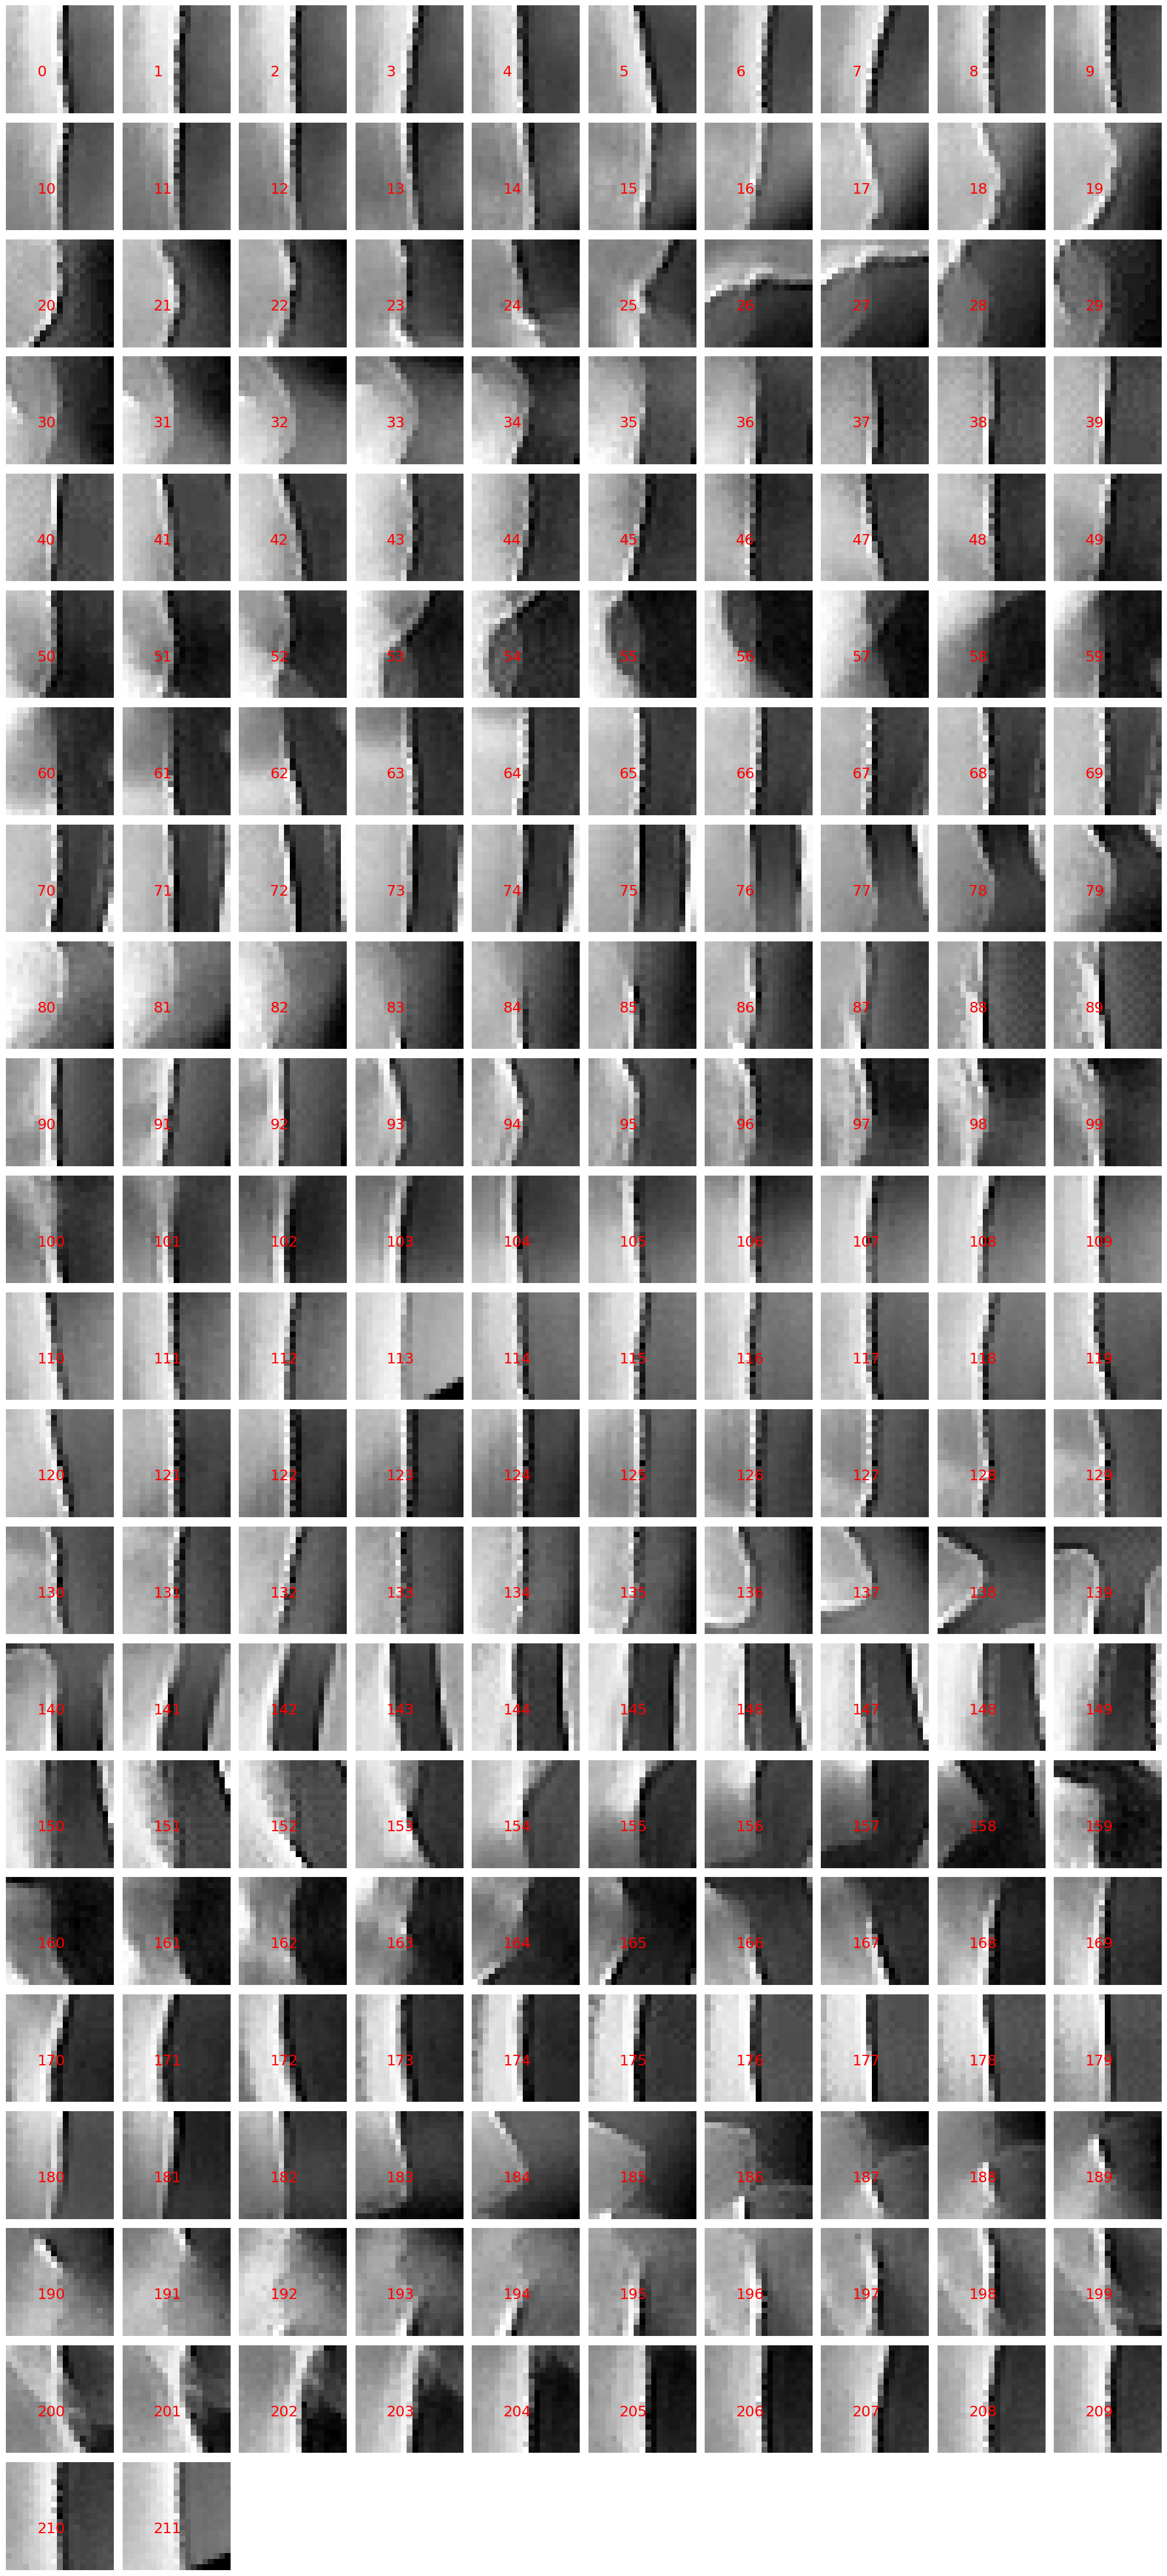

In [76]:
# img_EdgePatchs gorsellerini tek figurede gor (donmusmuyu kontrol et)
DisplayPatches(img_EdgePatchs)

In [77]:
# ImgEdgePatchs --> ImgEdgeVecs
img_EdgeVecs = EdgePatchs2EdgeVecs(img_EdgePatchs, draw=True)

EdgeVecs boyutu: (212, 33)


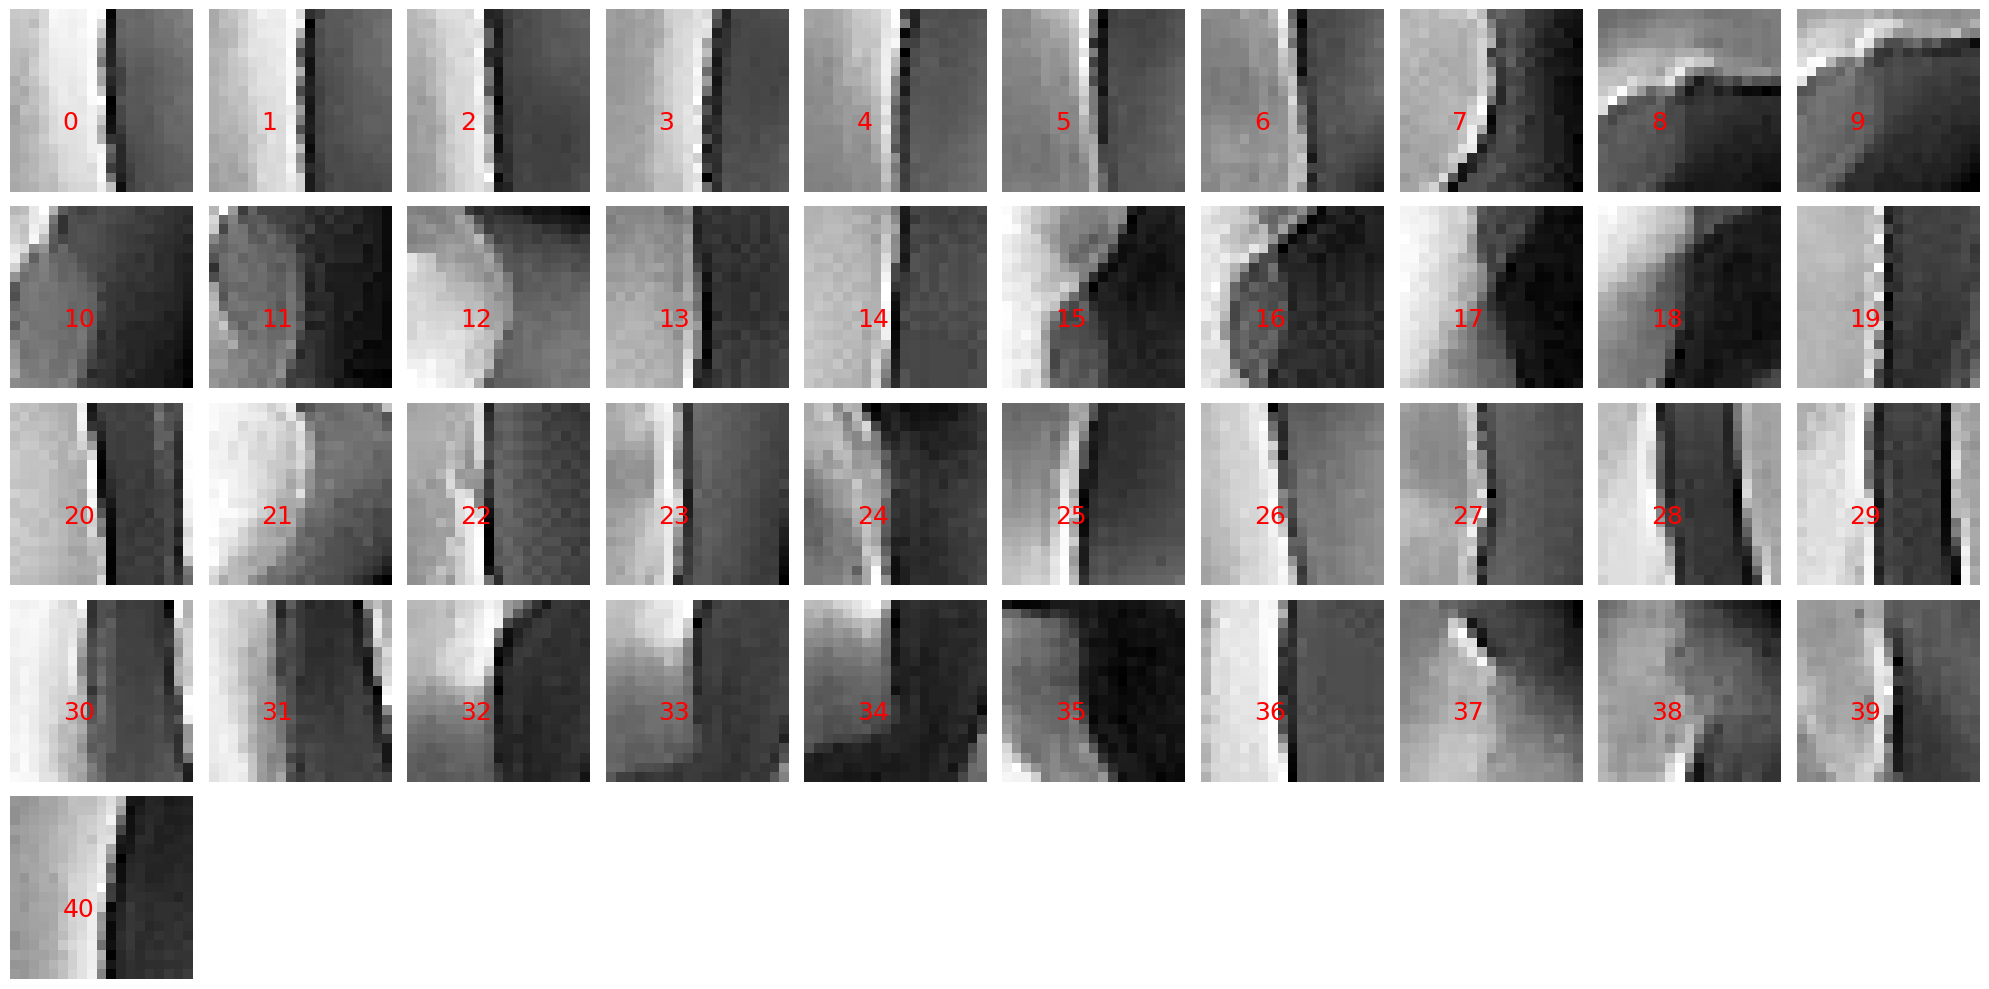

Vectors Size: (41, 33)
41 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\mxm_kenar_unique_vectors.pkl dosyasına kaydedildi.


In [78]:
# Farkli olan Patch ve onun Vec verisini tut
UniqueInds = FindUniqueVectors(img_EdgeVecs)
img_UniquePatchs, img_UniqueVecs = GetUniquePatchsVectors(img_EdgePatchs, img_EdgeVecs, UniqueInds, draw=True)
SaveUniqueVectors(img_UniqueVecs, filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\mxm_kenar_unique_vectors.pkl")

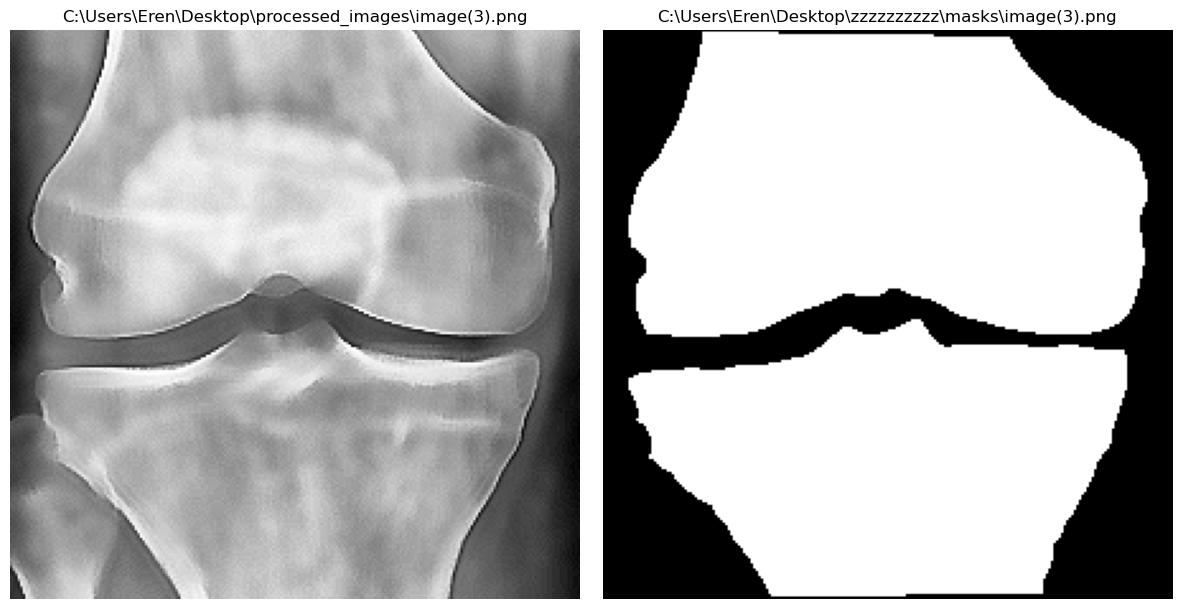

In [79]:
test_img, test_label = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(3).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(3).png', draw=True)

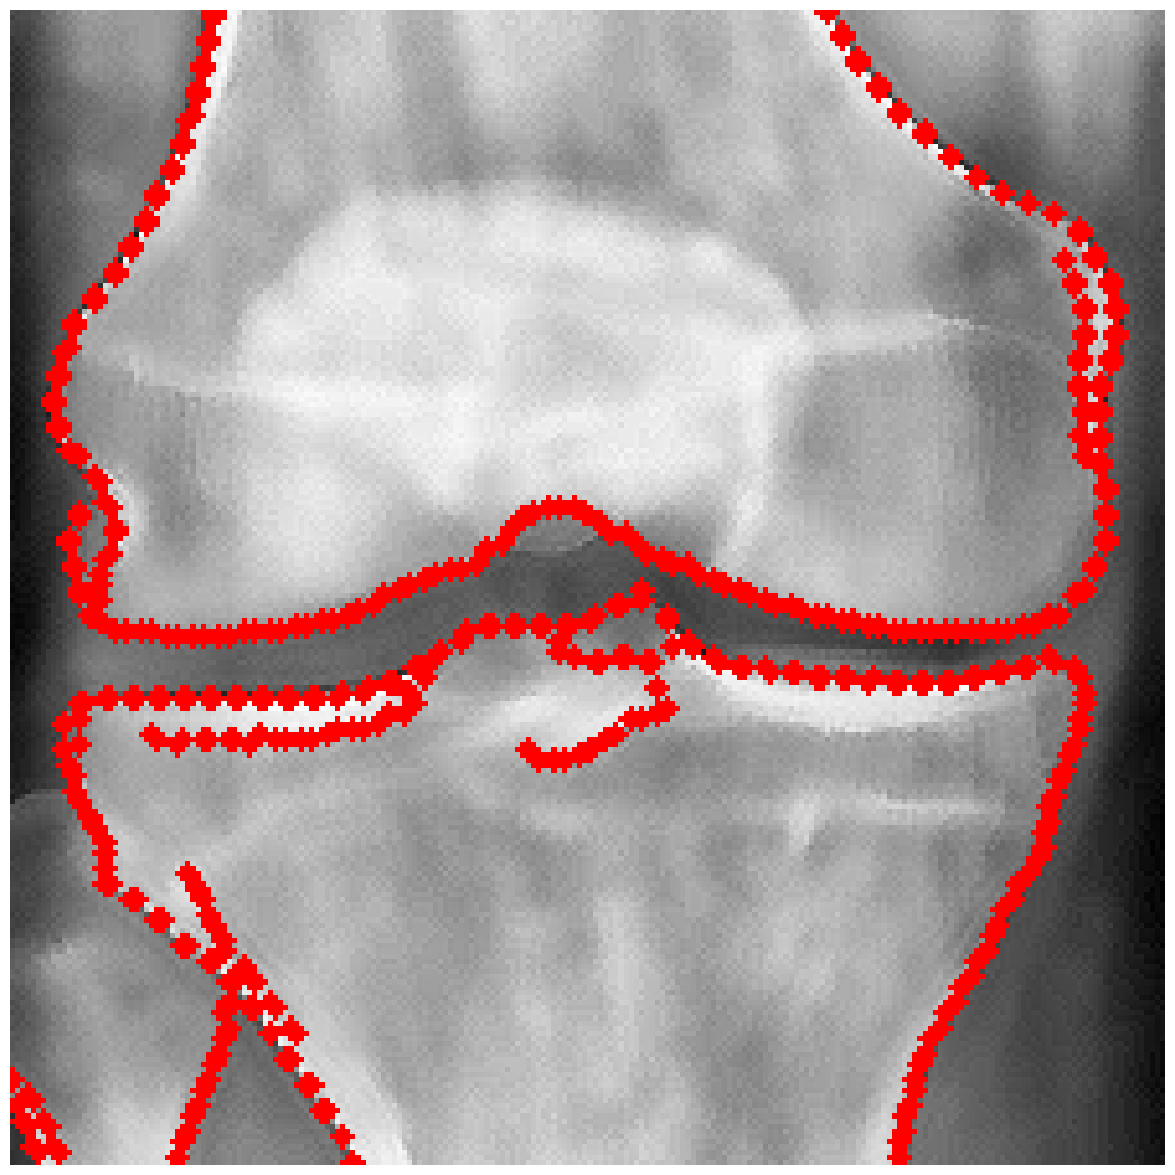

In [80]:
test_img_EdgePoints = GetCannyEdgePoints(test_img, sparsity_factor=5, draw=True)   # EdgePoints --> [p,2] --> (y,x)

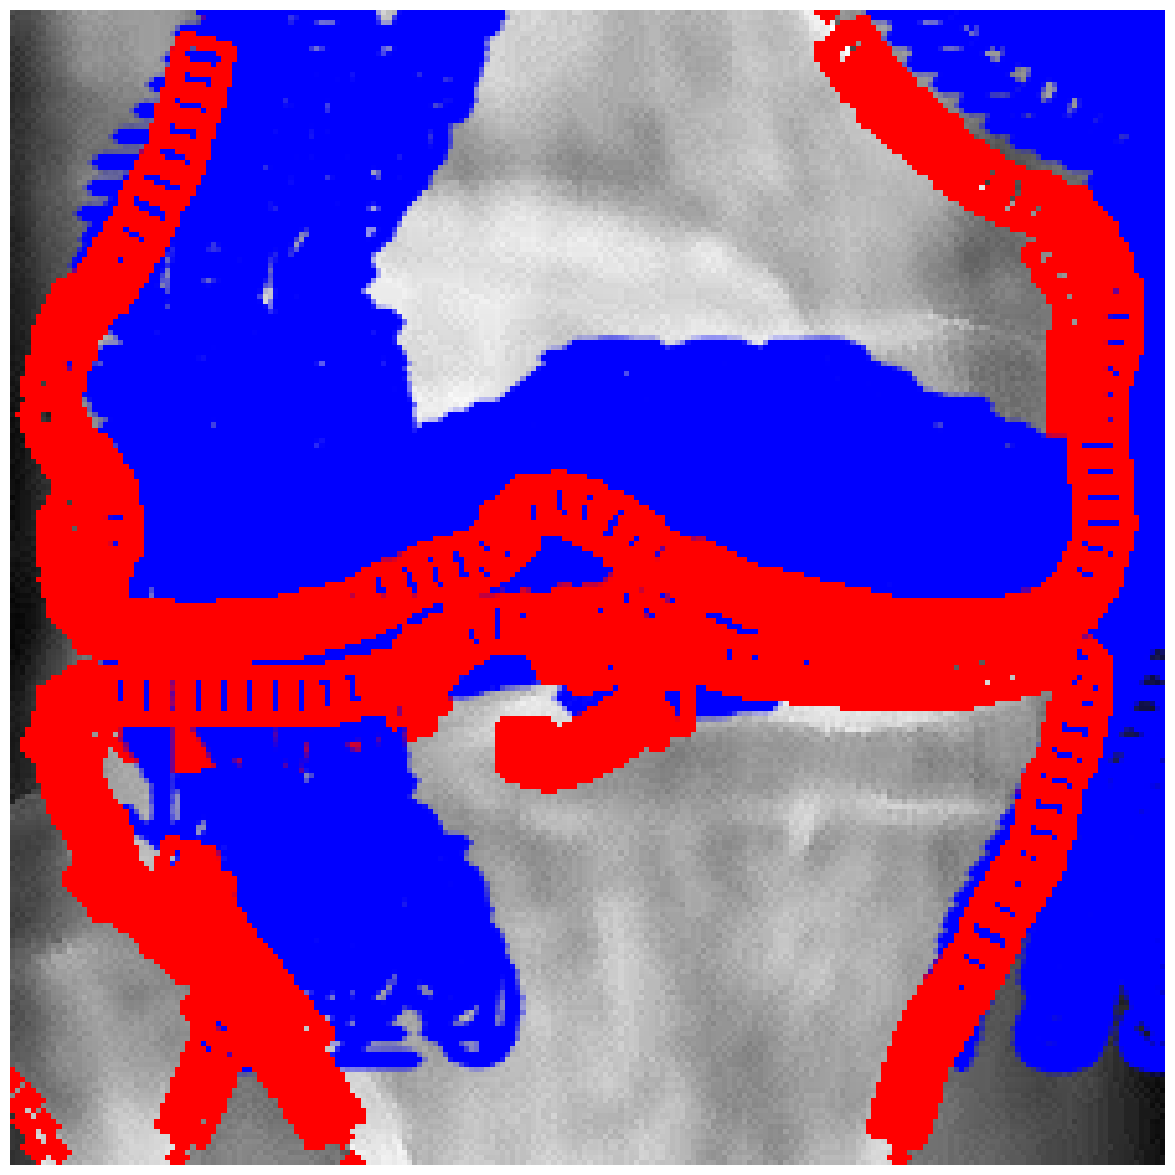

In [81]:
test_img_EdgePatchs, test_img_EdgePatchsInfo = GetEdgePatchs(test_img, test_img_EdgePoints, PatchSize=9, draw=True)

In [82]:
test_img_EdgeVecs = EdgePatchs2EdgeVecs(test_img_EdgePatchs, draw=True)

EdgeVecs boyutu: (413, 33)


In [83]:
unique_vector = LoadUniqueVectors(filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\mxm_kenar_unique_vectors.pkl")

TrueEdgePoints = Match(unique_vector, test_img_EdgeVecs, test_img_EdgePoints)

41 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\mxm_kenar_unique_vectors.pkl dosyasından yüklendi.


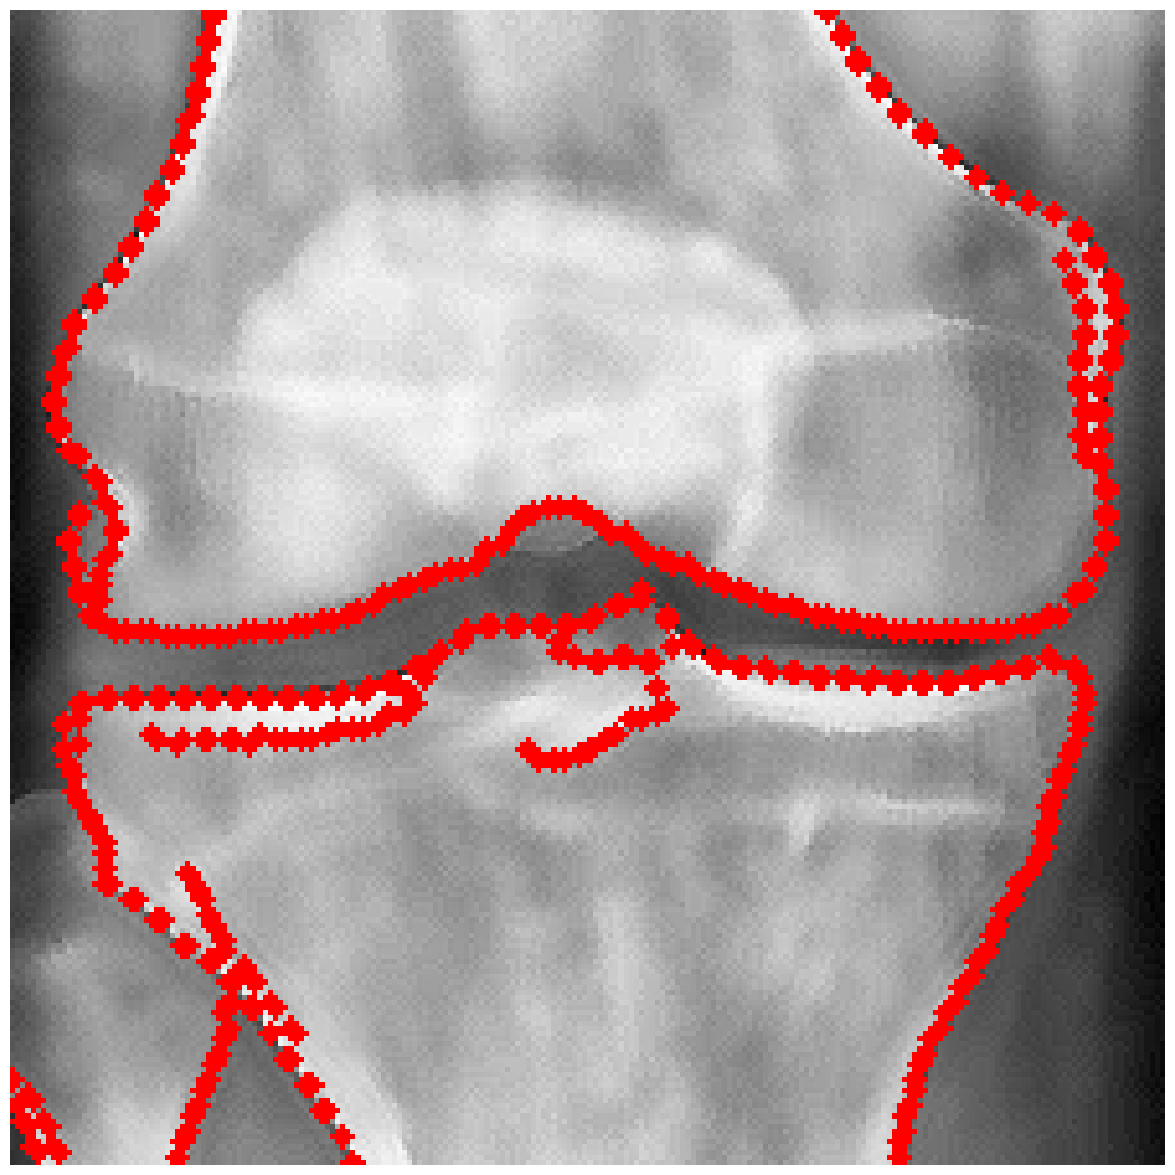

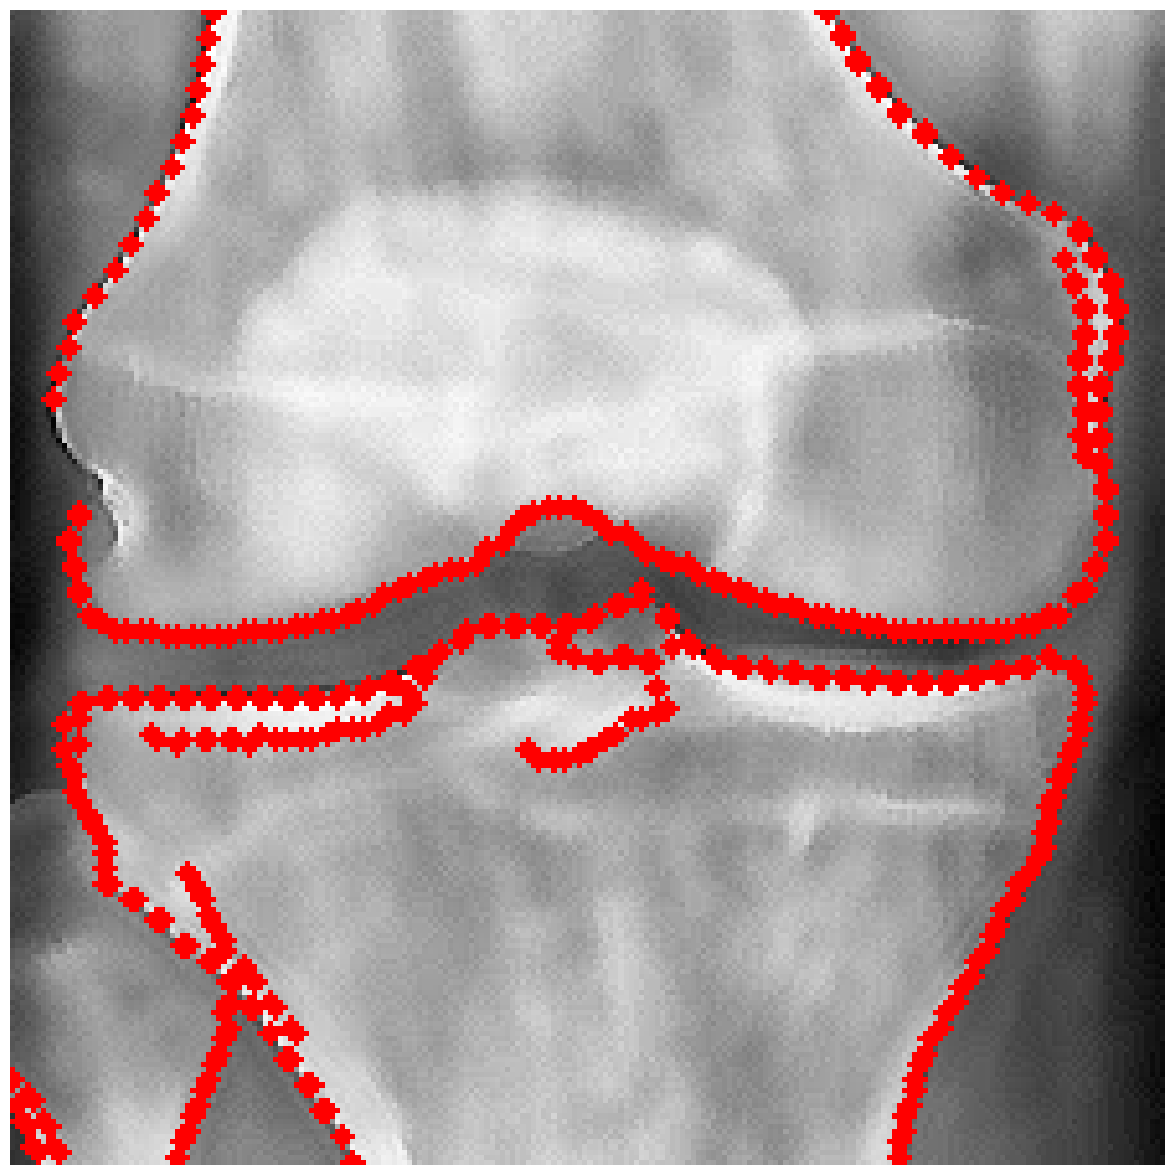

In [84]:
Drawing(test_img, EdgePoints=test_img_EdgePoints)

Drawing(test_img, EdgePoints=TrueEdgePoints)

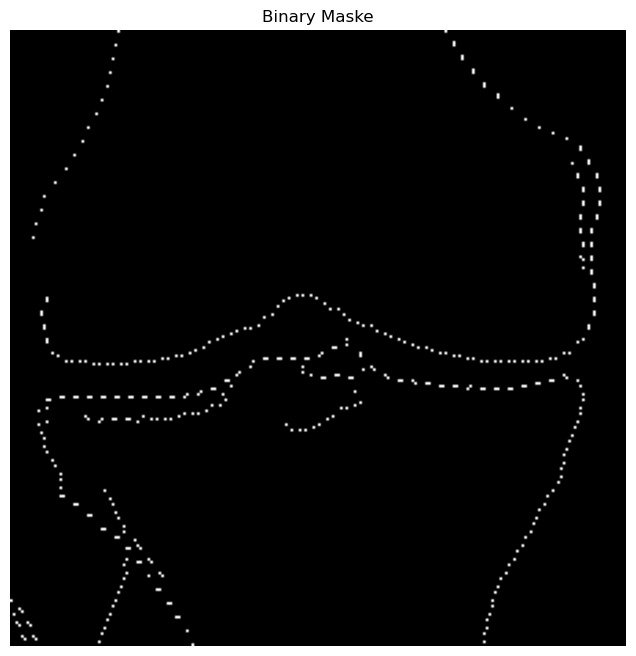

In [85]:
def create_binary_mask(img_shape, edge_points):
    """
    Kenar noktalarını (EdgePoints) kullanarak binary bir maske oluşturur.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y,x) formatındaki koordinat listesi.

    Returns:
    - mask: Binary maske (aynı boyutlarda, kenar noktaları 1, geri kalanı 0).
    """
    # Boş bir maske oluştur (0 değerleriyle)
    mask = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını maske üzerinde işaretle
    for y, x in edge_points:
        mask[y, x] = 255  # Noktaları beyaz yap

    return mask

test_image_shape = test_img.shape

TrueEdgePointss = TrueEdgePoints

binary_mask = create_binary_mask(test_image_shape, TrueEdgePointss)

plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Maske")
plt.axis('off')
plt.show()

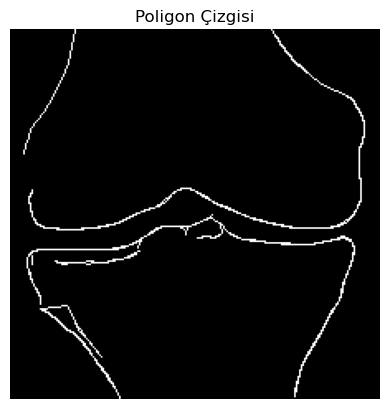

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance, min_line_length, min_component_size):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez,
    belirli bir uzunluktan kısa olan çizgileri çizmez ve küçük ayrık bileşenleri saf dışı bırakır.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.
    - min_line_length: Çizilecek minimum çizgi uzunluğu.
    - min_component_size: Görüntüde kalmasına izin verilen minimum bileşen boyutu (piksel sayısı).

    Returns:
    - contour_img: Kenar çizgileri çizilmiş ve küçük bileşenler kaldırılmış bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse ve çizgi uzunluğu yeterliyse çizgi çiz
        if distance <= max_distance and distance >= min_line_length:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    # Bağlı bileşen analizi ile küçük bileşenleri kaldır
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(contour_img, connectivity=8)

    # Yeni bir görüntü oluştur ve sadece büyük bileşenleri ekle
    filtered_img = np.zeros_like(contour_img)
    for i in range(1, num_labels):  # 0 etiket arka plan olduğu için atlanır
        if stats[i, cv2.CC_STAT_AREA] >= min_component_size:
            filtered_img[labels == i] = 255

    return filtered_img

# Örnek kullanım
# Örnek veri (test_image_shape ve TrueEdgePointss'i kullanıcı sağlamalı)
# test_image_shape = (512, 512)
# TrueEdgePointss = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 20
# min_line_length = 10
# min_component_size = 50  # Minimum bileşen boyutu (piksel sayısı)
test_image_shape = test_img.shape
contour_img = draw_contour(test_image_shape, TrueEdgePoints, max_distance=20, min_line_length=5, min_component_size=65)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()


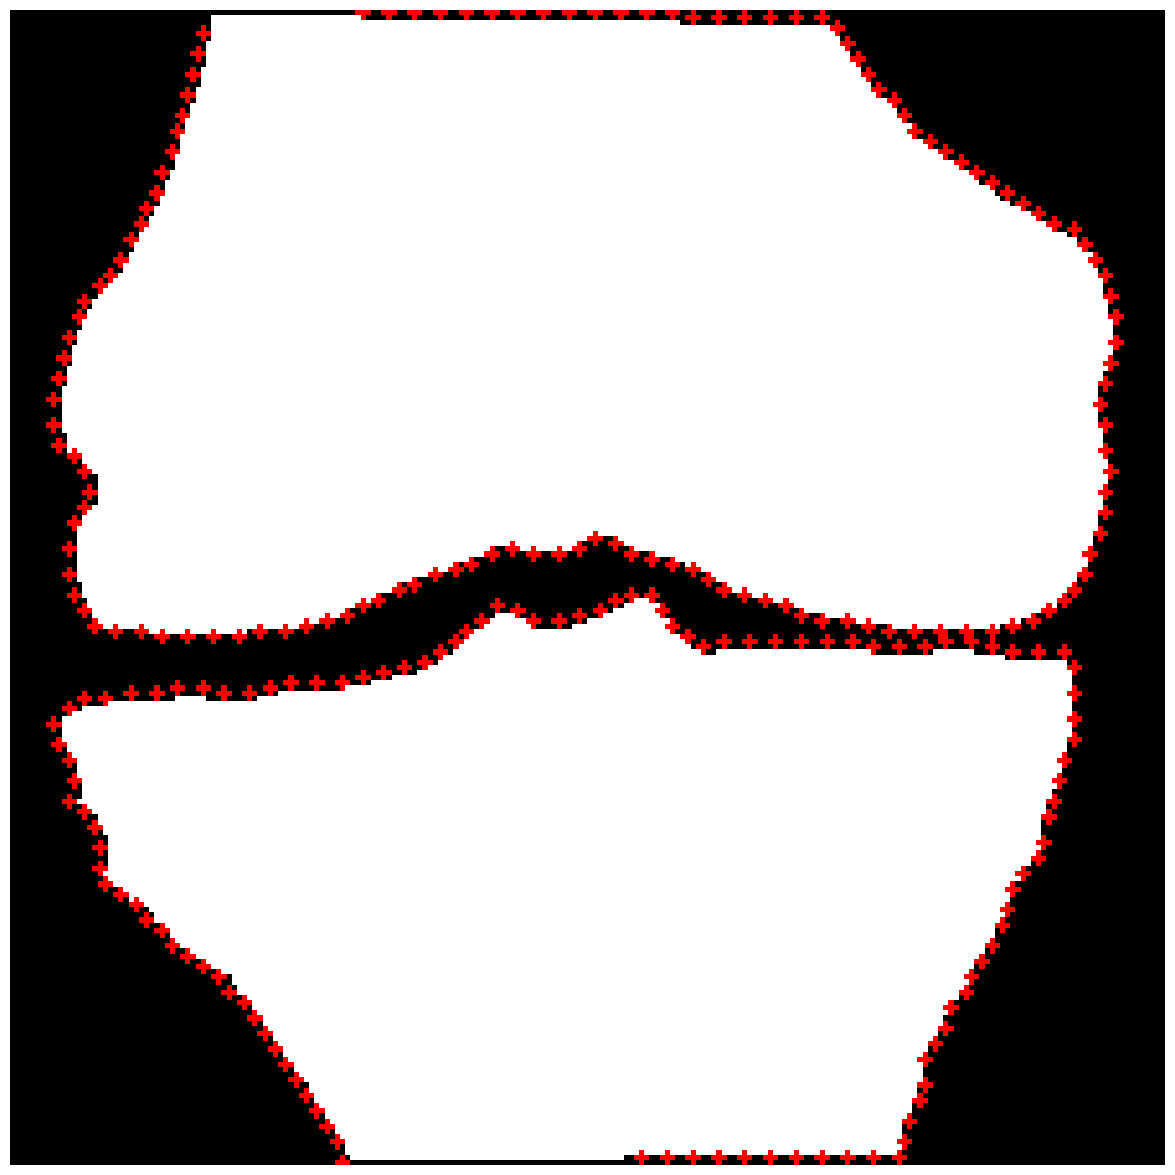

In [34]:
testlabel_EdgePoints = GetLabelEdgePoints(test_label, sparsity_factor=5,circle_radius=1, draw=True)

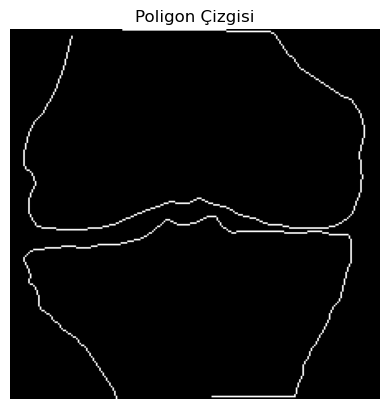

In [35]:
test_label_shape = test_label.shape

import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse çizgi çiz
        if distance <= max_distance:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

# Örnek kullanım
# Örnek veri (test_label_shape ve testlabel_EdgePoints'i kullanıcı sağlamalı)
# test_label_shape = (512, 512)
# testlabel_EdgePoints = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 100

contour_label = draw_contour(test_label_shape, testlabel_EdgePoints, max_distance=50)
plt.imshow(contour_label, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()

IoU: 0.1871


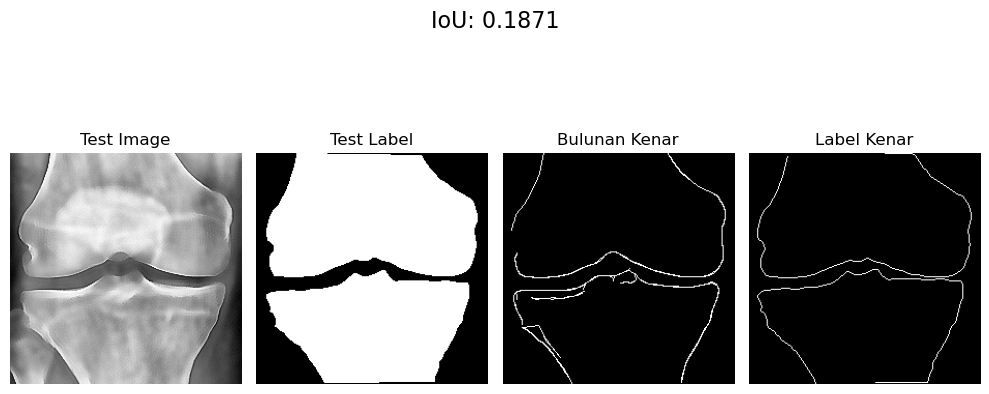

In [36]:
import numpy as np

def calculate_iou(binary_image1, binary_image2):
    """
    İki binary görüntü arasındaki Intersection over Union (IoU) değerini hesaplar.

    Args:
    - binary_image1: İlk binary görüntü (numpy array).
    - binary_image2: İkinci binary görüntü (numpy array).

    Returns:
    - IoU: İki görüntü arasındaki IoU değeri.
    """
    # Kesişim ve birleşim hesaplama
    intersection = np.logical_and(binary_image1, binary_image2).sum()
    union = np.logical_or(binary_image1, binary_image2).sum()

    # IoU hesaplama
    if union == 0:
        return 0  # Birleşim sıfırsa IoU tanımsızdır, bu nedenle 0 döndürüyoruz.
    iou = intersection / union
    return iou

# Örnek kullanım
# binary_image1 ve binary_image2'nin aynı boyutta olduğunu varsayıyoruz
# binary_image1 = np.array(...)  # İlk binary görüntü
# binary_image2 = np.array(...)  # İkinci binary görüntü

iou_value = calculate_iou(contour_img, contour_label)
print(f"IoU: {iou_value:.4f}")

# Görselleştirme
plt.figure(figsize=(10, 5))
# IoU başlığı
plt.suptitle(f"IoU: {iou_value:.4f}", fontsize=16)

# Bulunan kontur görüntüsü
plt.subplot(1, 4, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 2)
plt.imshow(test_label, cmap='gray')
plt.title("Test Label")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(contour_img, cmap='gray')
plt.title("Bulunan Kenar")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 4)
plt.imshow(contour_label, cmap='gray')
plt.title("Label Kenar")
plt.axis('off')

plt.tight_layout()
plt.show()

**(3.MADDE)Label kenarını K çaplı dairesel bir yapısal elementle genişlet. Bu bölgeye karşılık gelen kenar bilgisini kodla.Test görselinde eşleşen noktaları göster**

In [37]:
!pip install kymatio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from kymatio import Scattering2D
from skimage import measure
import pickle
import os


# Benzersiz vektörleri bir dosyaya kaydetmek için fonksiyon
def SaveUniqueVectors(vectors, filename="unique_vectors.pkl"):
    """
    Benzersiz vektörleri bir dosyaya kaydeder. Dosya yoksa oluşturur.

    Parameters:
    - vectors: Kaydedilecek vektörler (numpy array)
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)
    """
    if not os.path.exists(filename):
        print(f"{filename} oluşturuluyor...")

    with open(filename, "wb") as f:
        pickle.dump(vectors, f)
    print(f"{len(vectors)} vektör {filename} dosyasına kaydedildi.")


# Benzersiz vektörleri bir dosyadan yüklemek için fonksiyon
def LoadUniqueVectors(filename="unique_vectors.pkl"):
    """
    Dosyadan benzersiz vektörleri yükler.

    Parameters:
    - filename: Dosya adı (varsayılan: unique_vectors.pkl)

    Returns:
    - vectors: Yüklenen vektörler (numpy array)
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Dosya bulunamadı: {filename}")

    with open(filename, "rb") as f:
        vectors = pickle.load(f)
    print(f"{len(vectors)} vektör {filename} dosyasından yüklendi.")
    return vectors

#Burda K caplı dairesel genişletmeyle label  oluşturuldu 

def GetImageLabel(imgStr,labelStr,kernel_size,draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img) # print(img.max())

    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)
    # Dairesel yapısal eleman oluştur
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Dilation işlemi
    dilated_image = cv2.dilate(label, kernel, iterations=1)

    if draw:
        # Görüntü ve etiketleri yan yana çiz
        plt.figure(figsize=(12, 6))  # Şekil boyutunu ayarla
        plt.subplot(1, 3, 1)  # 1 satır, 2 sütun, ilk eksen
        plt.imshow(img, cmap='gray')  # img görüntüsünü göster
        plt.title(imgStr)  # Başlık
        plt.axis('off')  # Eksenleri kapat

        plt.subplot(1, 3, 2)  # 1 satır, 2 sütun, ikinci eksen
        plt.imshow(label, cmap='gray')  # label görüntüsünü göster
        plt.title(labelStr)  # Başlık
        plt.axis('off')  # Eksenleri kapat

        plt.subplot(1, 3, 3)  # 1 satır, 2 sütun, ikinci eksen
        plt.imshow(dilated_image, cmap='gray')  # label görüntüsünü göster
        plt.title("K Çaplı Genişletme")  # Başlık
        plt.axis('off')  # Eksenleri kapat

        plt.tight_layout()
        plt.show()  # Şekli göster
    return img, label, dilated_image

def ConvertAndNormalize(img):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Görüntüyü normalize et (0-255 aralığına getir)
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    return normalized_img

def Drawing(img, EdgePoints=None, EdgeLines=None, EdgePatchs=None, title=None, circle_radius = 2):
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if EdgePoints is not None:
        for point in EdgePoints:
            x, y = int(point[1]), int(point[0])  # x ve y koordinatları ters çevrilir
            cv2.circle(output_img, (x, y), circle_radius, (0, 0, 255), -1)  # Kırmızı daire

    if EdgeLines is not None:
        for Line in EdgeLines:
            start_point = Line["StartPointYX"]
            stop_point = Line["StopPointYX"]
            cv2.line(output_img, start_point[::-1], stop_point[::-1], color = (255, 255, 0) , thickness = 2)

    if EdgePatchs is not None:
        # Img uzerine Patch ciz
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 0, 0)
        thickness = 2
        for k, (x,y,PatchSize,angle) in enumerate(EdgePatchs):
            rect = cv2.boxPoints(((float(x), float(y)), (PatchSize, PatchSize), angle))
            rect = np.intp(rect)
            cv2.drawContours(output_img, [rect], 0, (0, 0, 255), 2)

            # Draw a line indicating the angle
            end_x = int(x + (PatchSize / 2) * np.cos(np.radians(angle)))
            end_y = int(y + (PatchSize / 2) * np.sin(np.radians(angle)))
            cv2.line(output_img, (x, y), (end_x, end_y), (0, 0, 255), 2)
            cv2.putText(output_img, str(k), (x, y - 10), font, font_scale, color, thickness, cv2.LINE_AA)

    # Görüntü boyutlarına göre figsize hesaplama
    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (15 * aspect_ratio, 15)  # Oranı koruyarak uygun bir ölçekleme

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()

def GetLabelEdgePoints(img, sparsity_factor=1, circle_radius = 10, draw=False):
    contours = measure.find_contours(img, level=0.5)
    # Tüm sınır piksellerini birleştir
    boundary_points = np.vstack(contours)

    # Sparsity factor ile seyrekleştirme
    if sparsity_factor > 1:
        boundary_points = boundary_points[::sparsity_factor]

    if draw:
        Drawing(img, EdgePoints=boundary_points, circle_radius=circle_radius)

    return boundary_points.astype(int)

def GetCannyEdgePoints(img, sparsity_factor=1, draw=False):
    blurimg = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurimg, 40, 190)
    CannyEdgePoints, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    EdgePoints = []
    for ObjPoints in CannyEdgePoints:
        EdgePoints = EdgePoints + [(point[0][1], point[0][0]) for i, point in enumerate(ObjPoints) if i % sparsity_factor == 0]

    if draw:
        Drawing(img, EdgePoints=EdgePoints)

    return EdgePoints

def EuclidDistance(point1,point2):
    y1,x1 = point1
    y2,x2 = point2
    return int(np.sqrt((x1-x2)**2 + (y1-y2)**2))

def GetEdgePatchs(img, EdgePoints, PatchSize=11, draw=True):
    EdgePatchs = []
    EdgePatchsInfo = []
    for i in range(len(EdgePoints)):
        # Çizginin başlangıç noktası
        y, x = EdgePoints[i]

        # Çizginin yönü
        prev_idx = (i - 1) % len(EdgePoints)
        next_idx = (i + 1) % len(EdgePoints)
        y1, x1 = EdgePoints[prev_idx]
        y2, x2 = EdgePoints[next_idx]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.atan2(-dx, dy)

        # Patch al
        center = (float(x), float(y))
        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(angle), scale=1.0)
        rows, cols = img.shape
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        # Patch sınırlarını kontrol et
        y_start, y_end = y - PatchSize, y + PatchSize + 1
        x_start, x_end = x - PatchSize, x + PatchSize + 1

        if y_start < 0 or y_end > rows or x_start < 0 or x_end > cols:
            # Patch görüntü sınırlarının dışında, atla
            continue

        EdgePatch = rotated_image[y-PatchSize:y+PatchSize+1, x-PatchSize:x+PatchSize+1]

        EdgePatchs.append(EdgePatch)
        EdgePatchsInfo.append([x,y,PatchSize,np.degrees(angle)])

    if draw:
        Drawing(img, EdgePoints=EdgePoints, EdgePatchs = EdgePatchsInfo)

    return EdgePatchs, EdgePatchsInfo

def DisplayPatches(EdgePatchs, max_cols=10):
    # Toplam patch sayısı
    num_patches = len(EdgePatchs)

    # Sütun sayısı (max_cols ile sınırlı)
    cols = min(max_cols, num_patches)

    # Satır sayısını hesapla
    rows = math.ceil(num_patches / cols)

    # Şekil oluşturma
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(-1)  # Tek boyutlu diziye dönüştür

    for i, ax in enumerate(axes):
        if i < num_patches:
            ax.imshow(EdgePatchs[i], cmap='gray')
            ax.text(5, 10, str(i), color='red', fontsize=18, ha='left', va='top')
            ax.axis('off')
        else:
            ax.axis('off')  # Fazla eksenleri kapat

    plt.tight_layout()
    plt.show()

def GetWSN(J,PatchSize):
    S = Scattering2D(J=J, shape=(PatchSize, PatchSize), L=2, max_order=2, frontend='numpy')
    return S

def EdgePatchs2EdgeVecs(EdgePatchs,draw = False):
    # EdgePatchs --> EdgeVecs
    PatchSize = len(EdgePatchs[0])

    S = GetWSN(J=4,PatchSize=PatchSize) # Scattering Network

    EdgeVecs = []
    for img in EdgePatchs:
        img = img.astype(np.float32)
        coeffs = S(img)                                 # (33, 6, 6)
        vec = coeffs.mean(axis=(1, 2)).reshape(-1, 1)   # (33, 1)
        EdgeVecs.append(vec)
    EdgeVecs = np.squeeze(np.array(EdgeVecs))

    if draw:
        print("EdgeVecs boyutu:",EdgeVecs.shape)

    return EdgeVecs

def FindUniqueVectors(vectors, threshold=10):
    unique_indices = []
    for i, vector in enumerate(vectors):
        is_unique = True
        for j in unique_indices:
            if np.linalg.norm(vector - vectors[j]) < threshold:
                is_unique = False
                break
        if is_unique:
            unique_indices.append(i)
    return unique_indices

def GetUniquePatchsVectors(EdgePatchs, EdgeVecs, UniqueInds, draw=False):
    Patchs = []
    Vectors = []
    for idx in UniqueInds:
            Patchs.append(EdgePatchs[idx])
            Vectors.append(EdgeVecs[idx])
    Vectors = np.squeeze(np.array(Vectors))
    if draw:
        DisplayPatches(Patchs)
        print("Vectors Size:", Vectors.shape)

    return Patchs, Vectors

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def Match(img_UniqueVecs, test_img_EdgeVecs, test_img_EdgePoints, threshold=5):
    TrueEdgePoints = []
    for i, test_vec in enumerate(test_img_EdgeVecs):
        similarities = [np.linalg.norm(test_vec - unique_vec) for unique_vec in img_UniqueVecs]
        #similarities = [cosine_similarity(test_vec - unique_vec) for unique_vec in img_UniqueVecs]
        if max(similarities) >= threshold:
            TrueEdgePoints.append(test_img_EdgePoints[i])

    return TrueEdgePoints

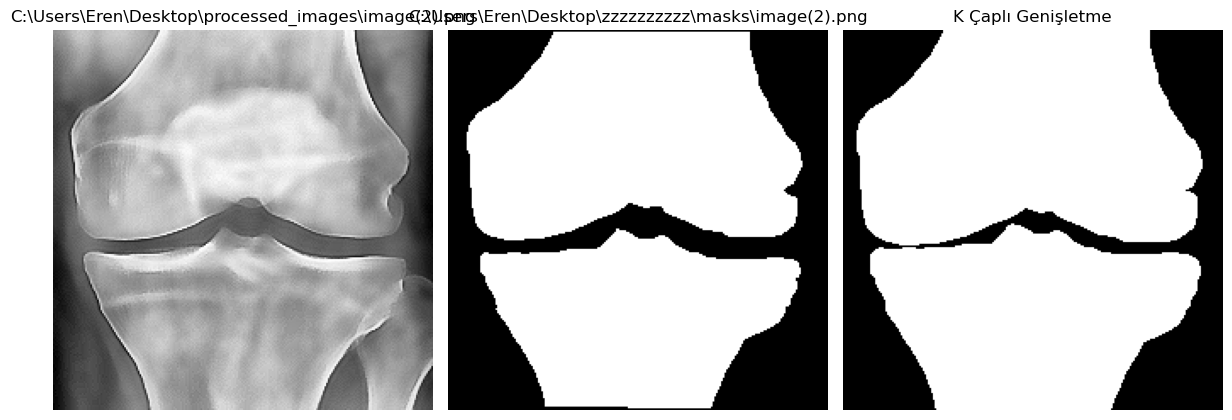

In [55]:
# img ve label gorselleri al
img, label, dilated = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(2).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(2).png',7,draw=True)

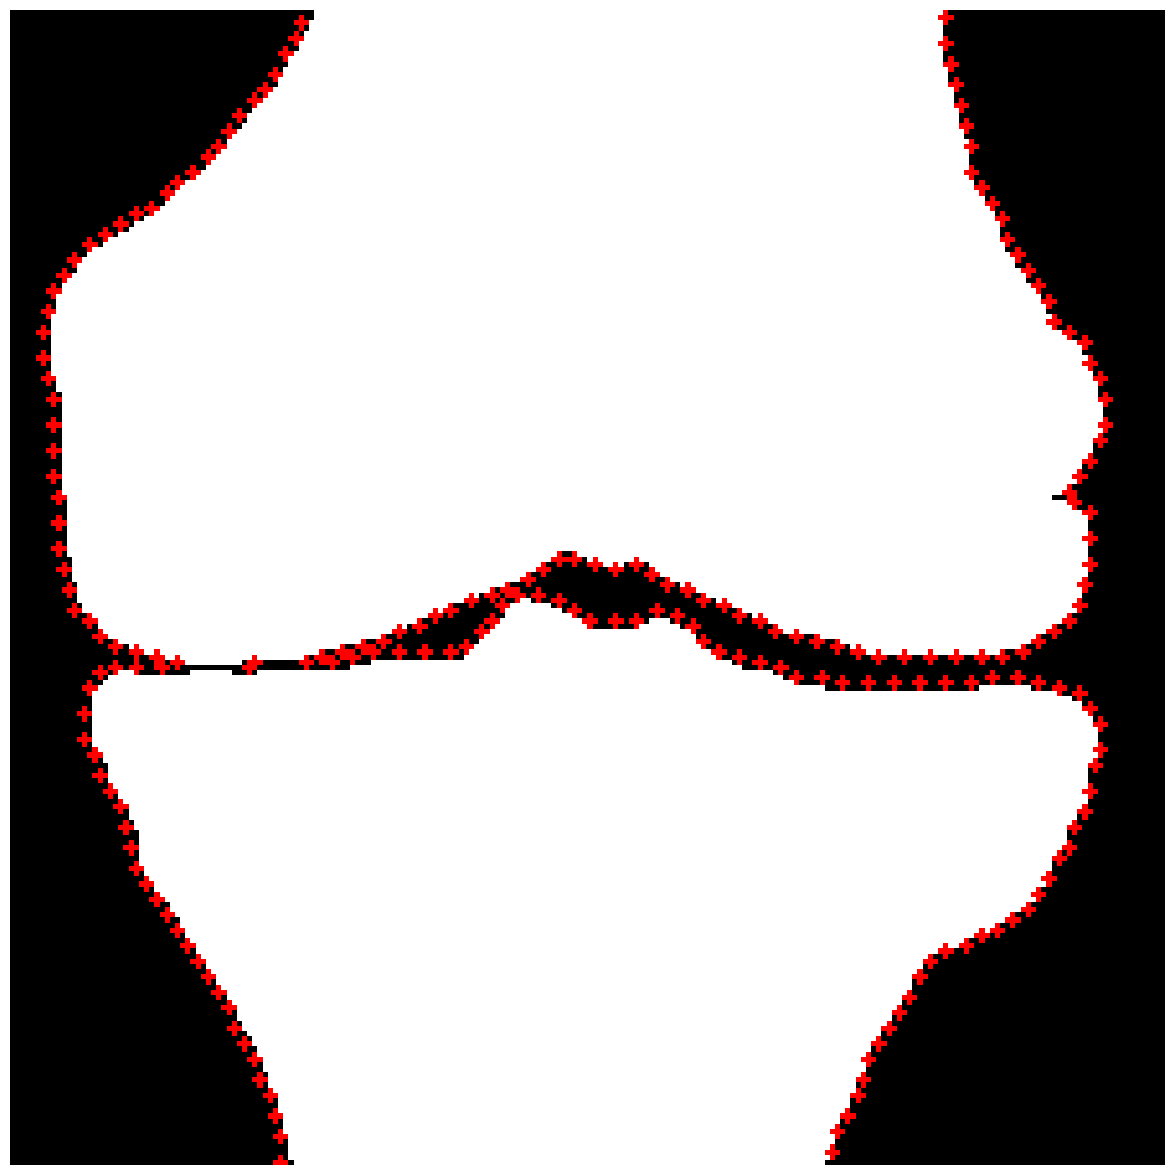

In [56]:
# Kenar Gorsellerinia Kodla
img_EdgePoints = GetLabelEdgePoints(dilated, sparsity_factor=5, circle_radius=1, draw=True)   # EdgePoints --> [p,2] --> (y,x)

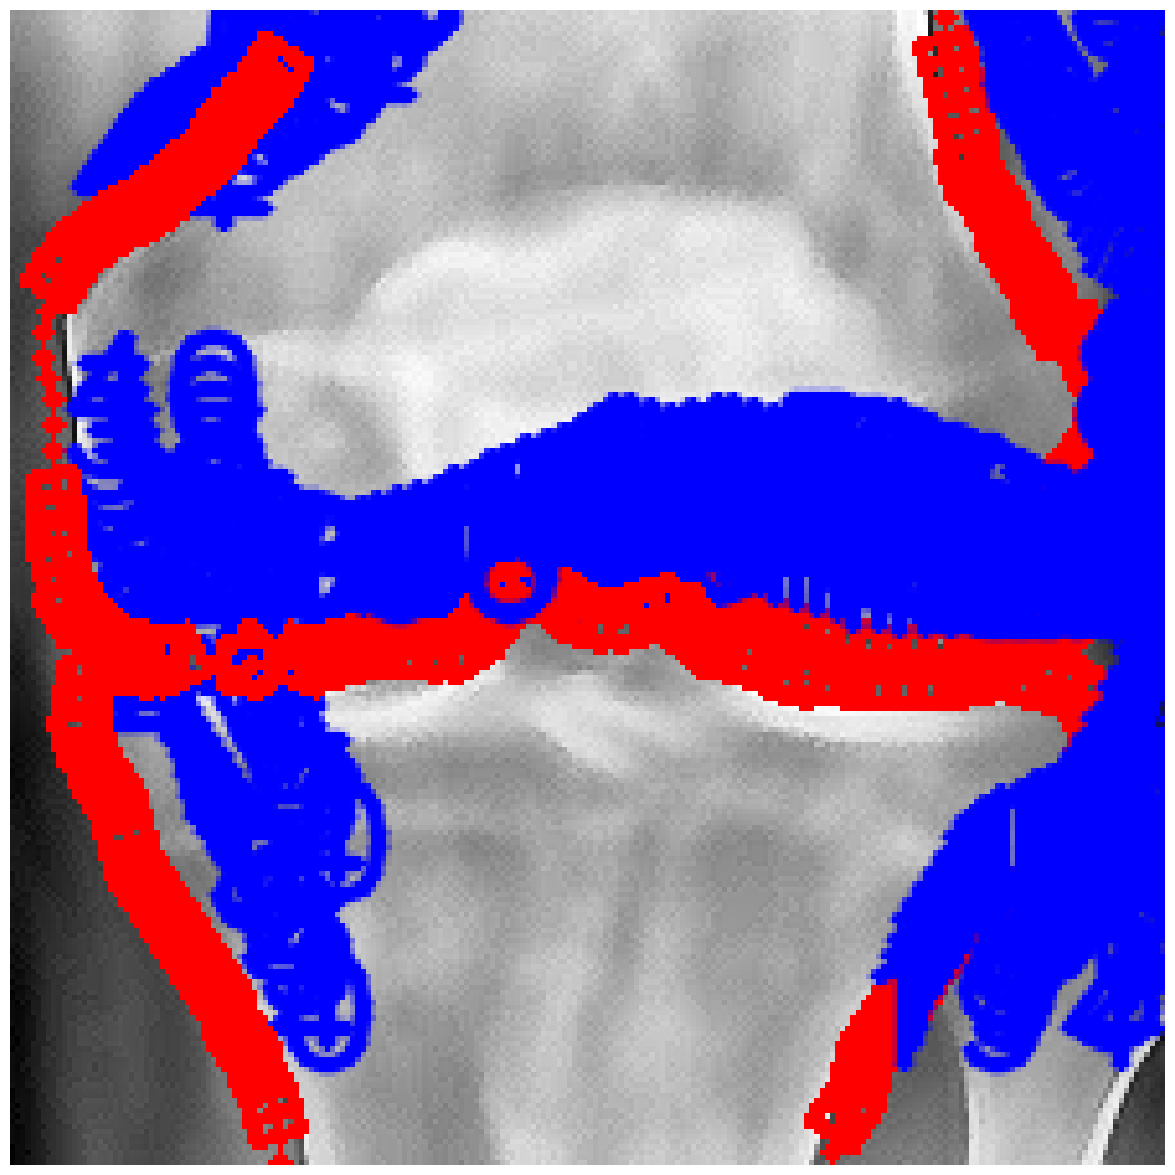

In [57]:
# img_EdgePoints --> img_EdgePatchs
img_EdgePatchs, img_EdgePatchsInfo = GetEdgePatchs(img, img_EdgePoints, PatchSize=9, draw=True)  # M = 2*PatchSize + 1,  MxM = 101x101

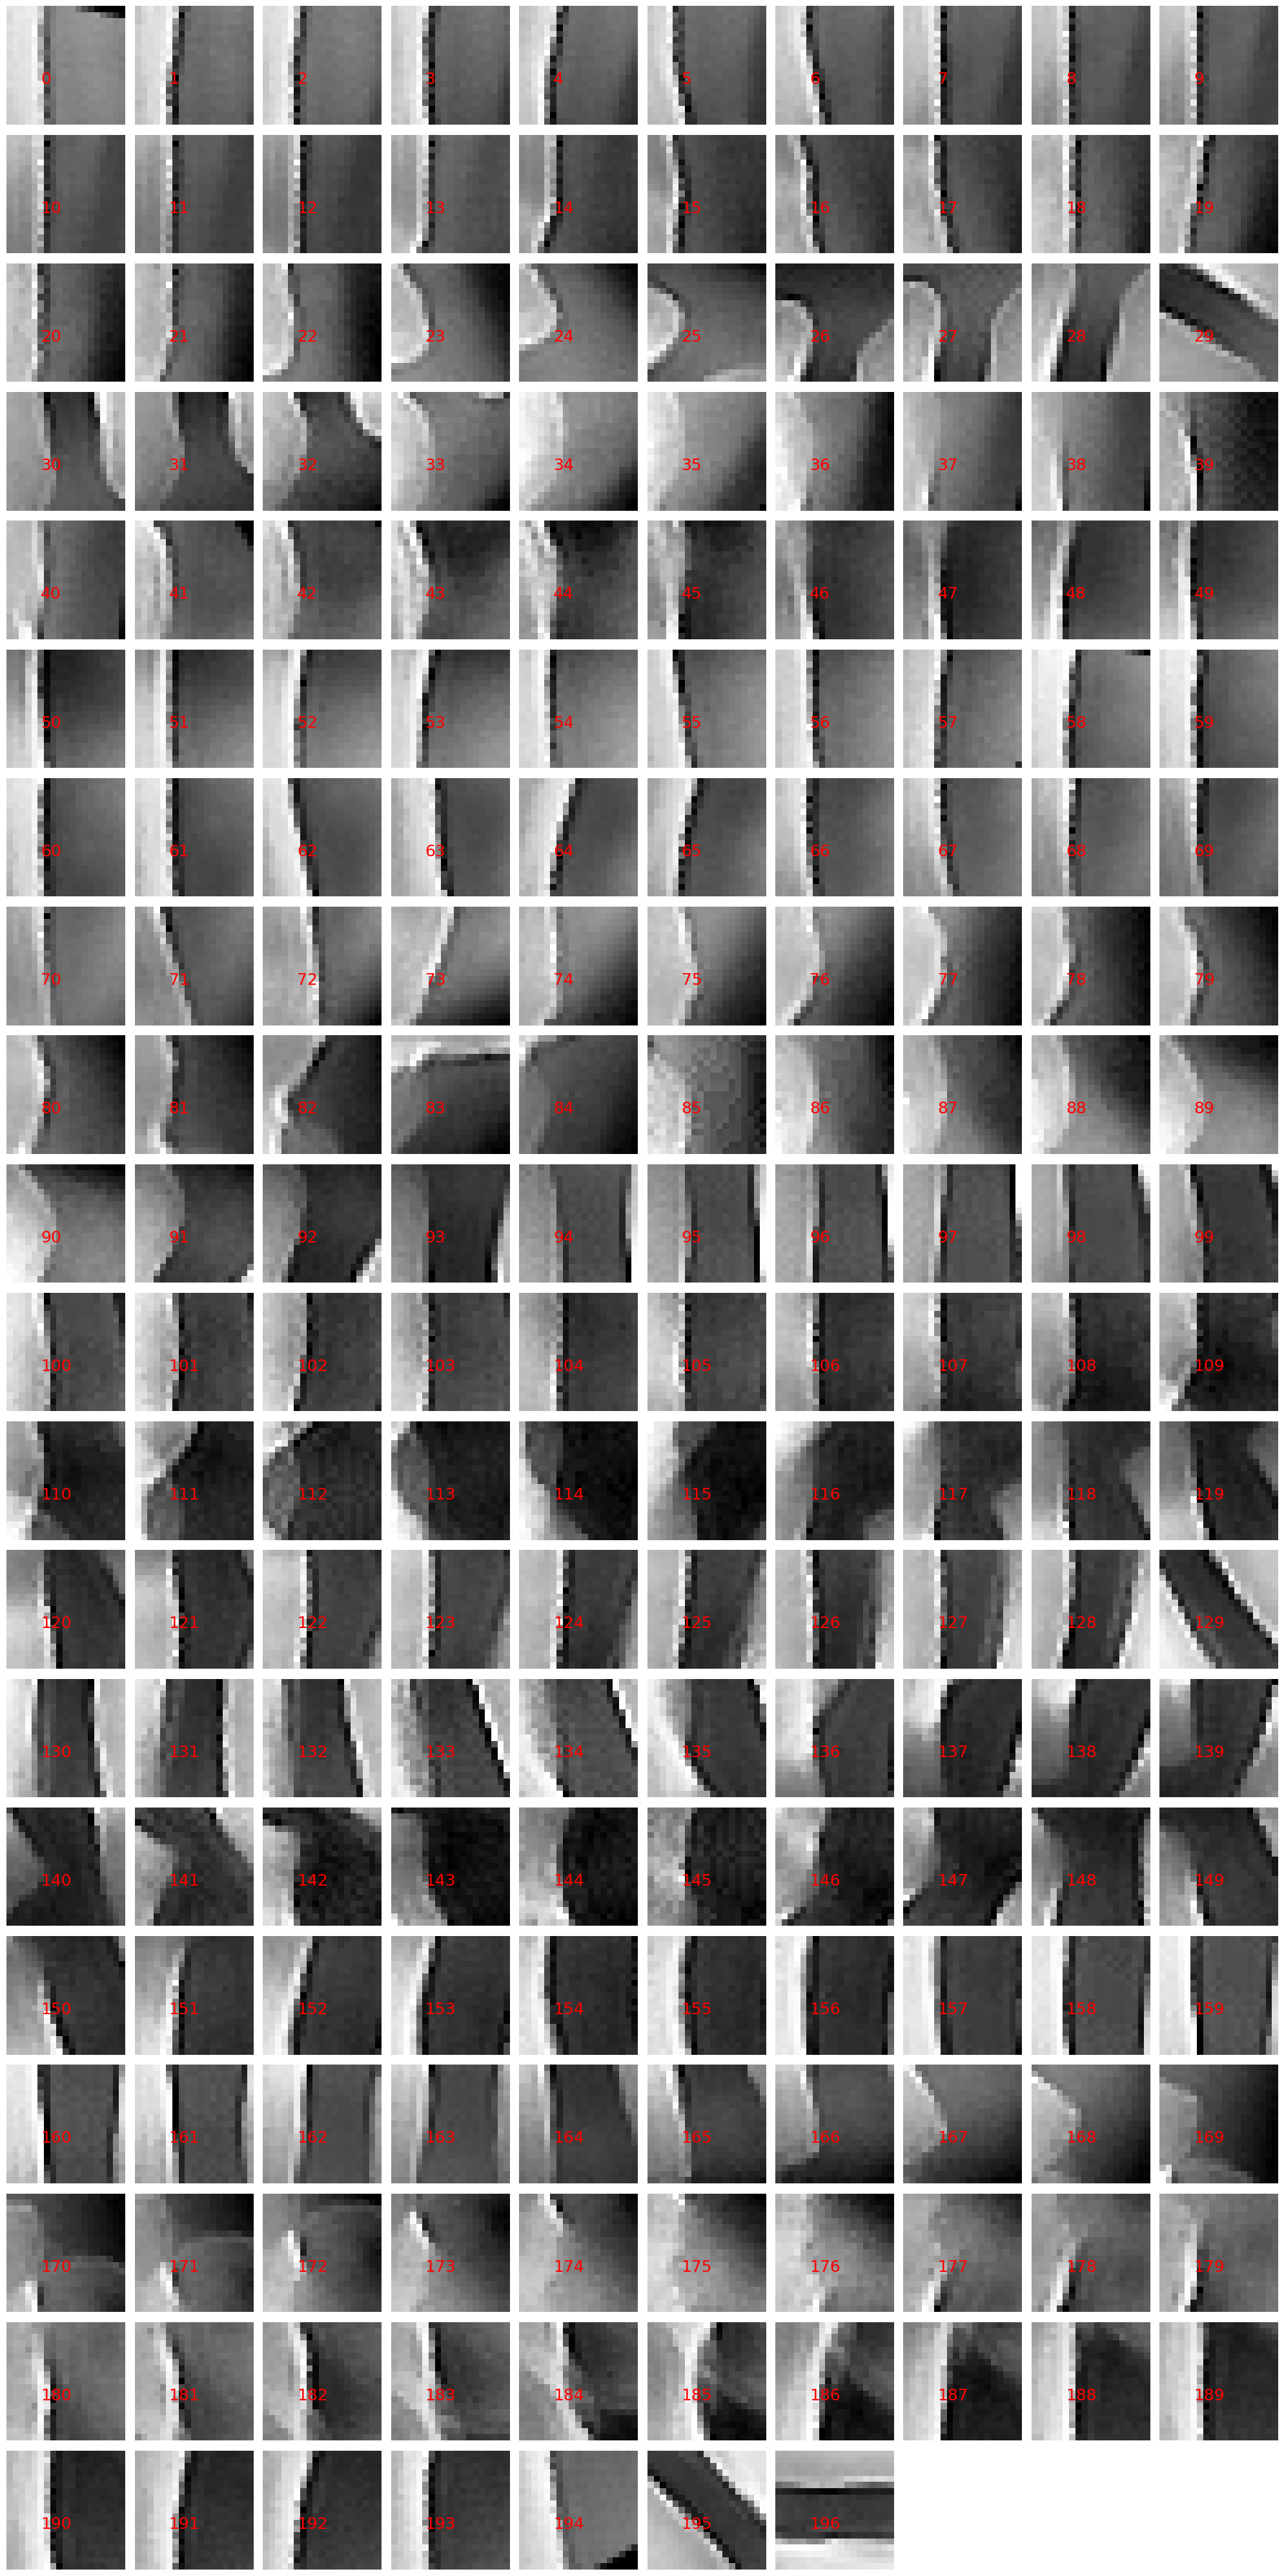

In [58]:
# img_EdgePatchs gorsellerini tek figurede gor (donmusmuyu kontrol et)
DisplayPatches(img_EdgePatchs)

In [59]:
# ImgEdgePatchs --> ImgEdgeVecs
img_EdgeVecs = EdgePatchs2EdgeVecs(img_EdgePatchs, draw=True)

EdgeVecs boyutu: (197, 33)


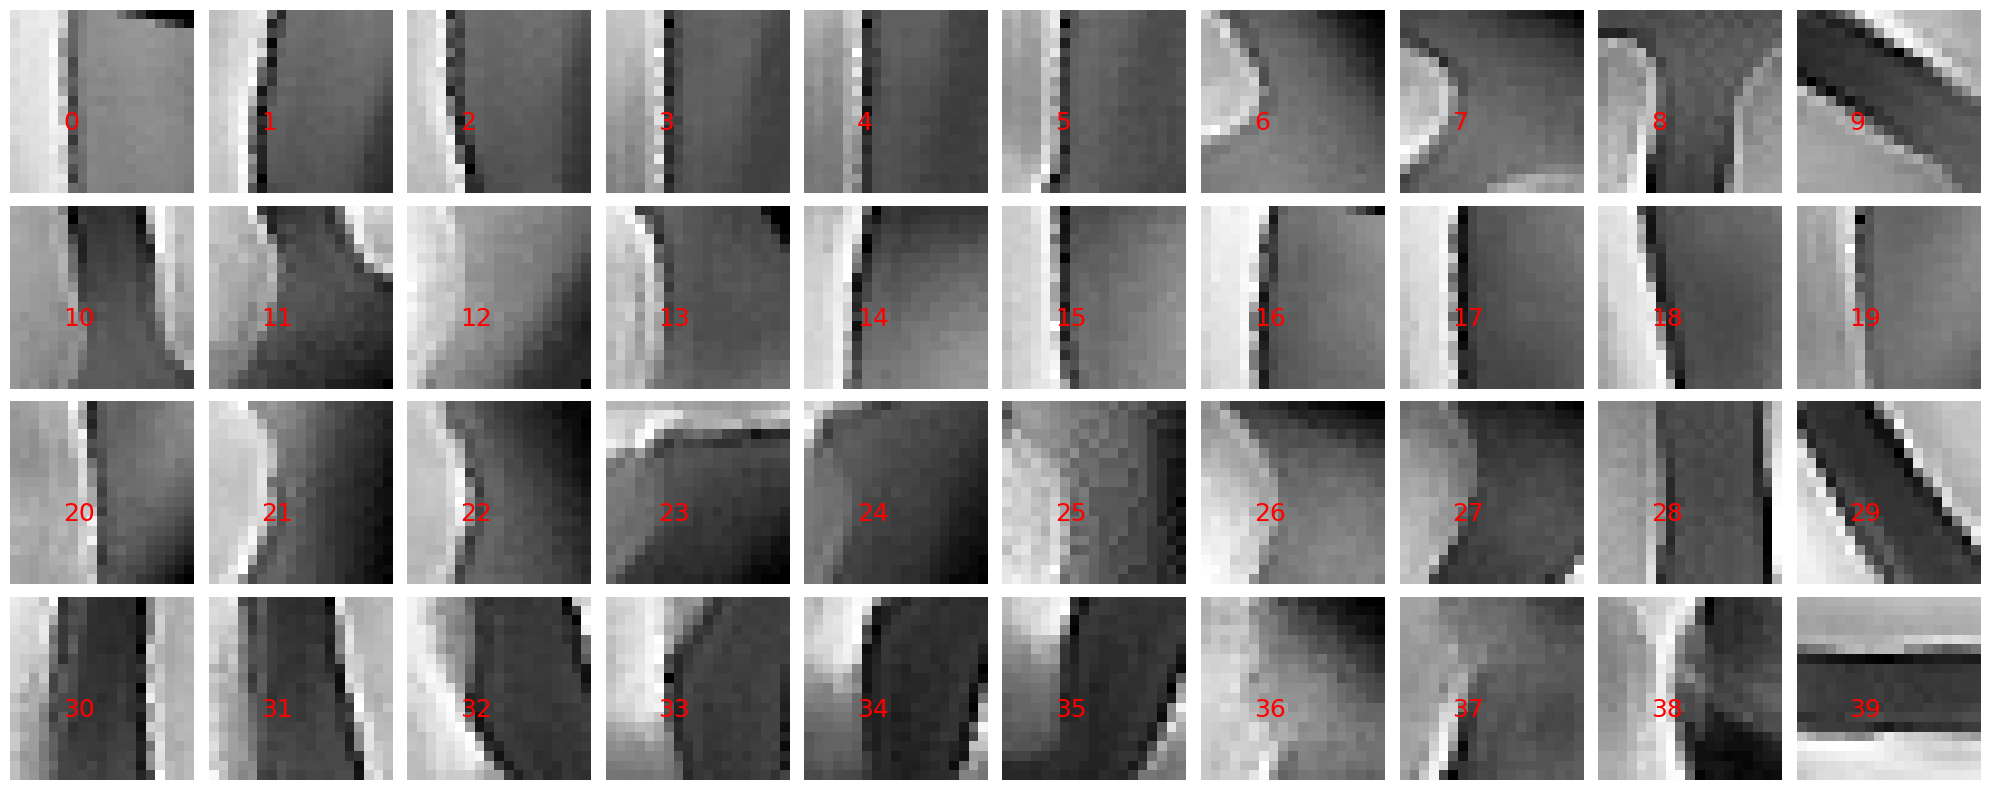

Vectors Size: (40, 33)
40 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\k_capli_kenar_unique_vectors.pkl dosyasına kaydedildi.


In [60]:
# Farkli olan Patch ve onun Vec verisini tut
UniqueInds = FindUniqueVectors(img_EdgeVecs)
img_UniquePatchs, img_UniqueVecs = GetUniquePatchsVectors(img_EdgePatchs, img_EdgeVecs, UniqueInds, draw=True)
SaveUniqueVectors(img_UniqueVecs, filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\k_capli_kenar_unique_vectors.pkl")

Test labeli IoU karşılaştırmak için alınıyor fakat burdaki genişletilmiş label kullanılmayacak

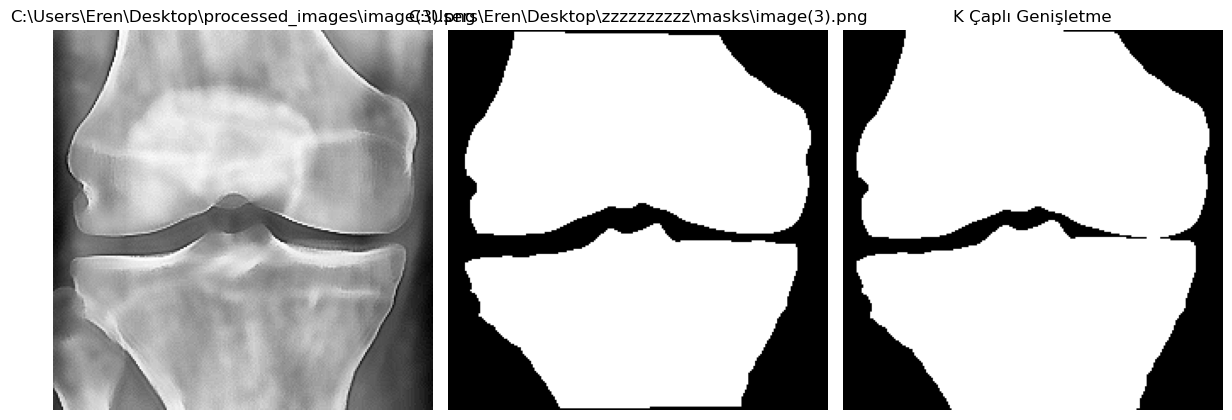

In [61]:
test_img, test_label, test_dila = GetImageLabel(r'C:\Users\Eren\Desktop\processed_images\image(3).png',r'C:\Users\Eren\Desktop\zzzzzzzzzz\masks\image(3).png',5, draw=True)

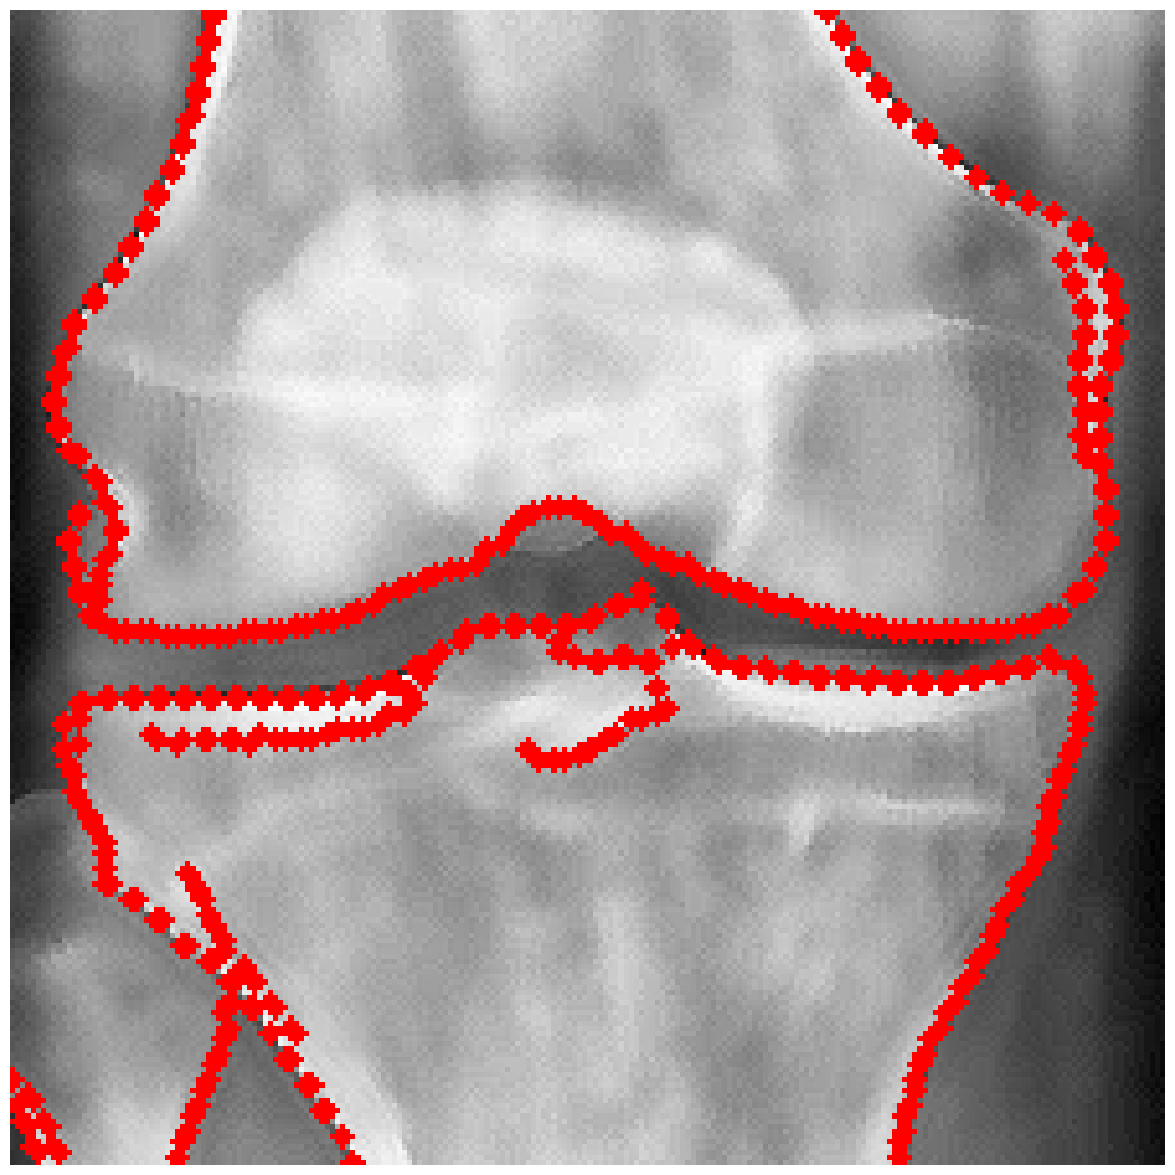

In [62]:
test_img_EdgePoints = GetCannyEdgePoints(test_img, sparsity_factor=5, draw=True)   # EdgePoints --> [p,2] --> (y,x)

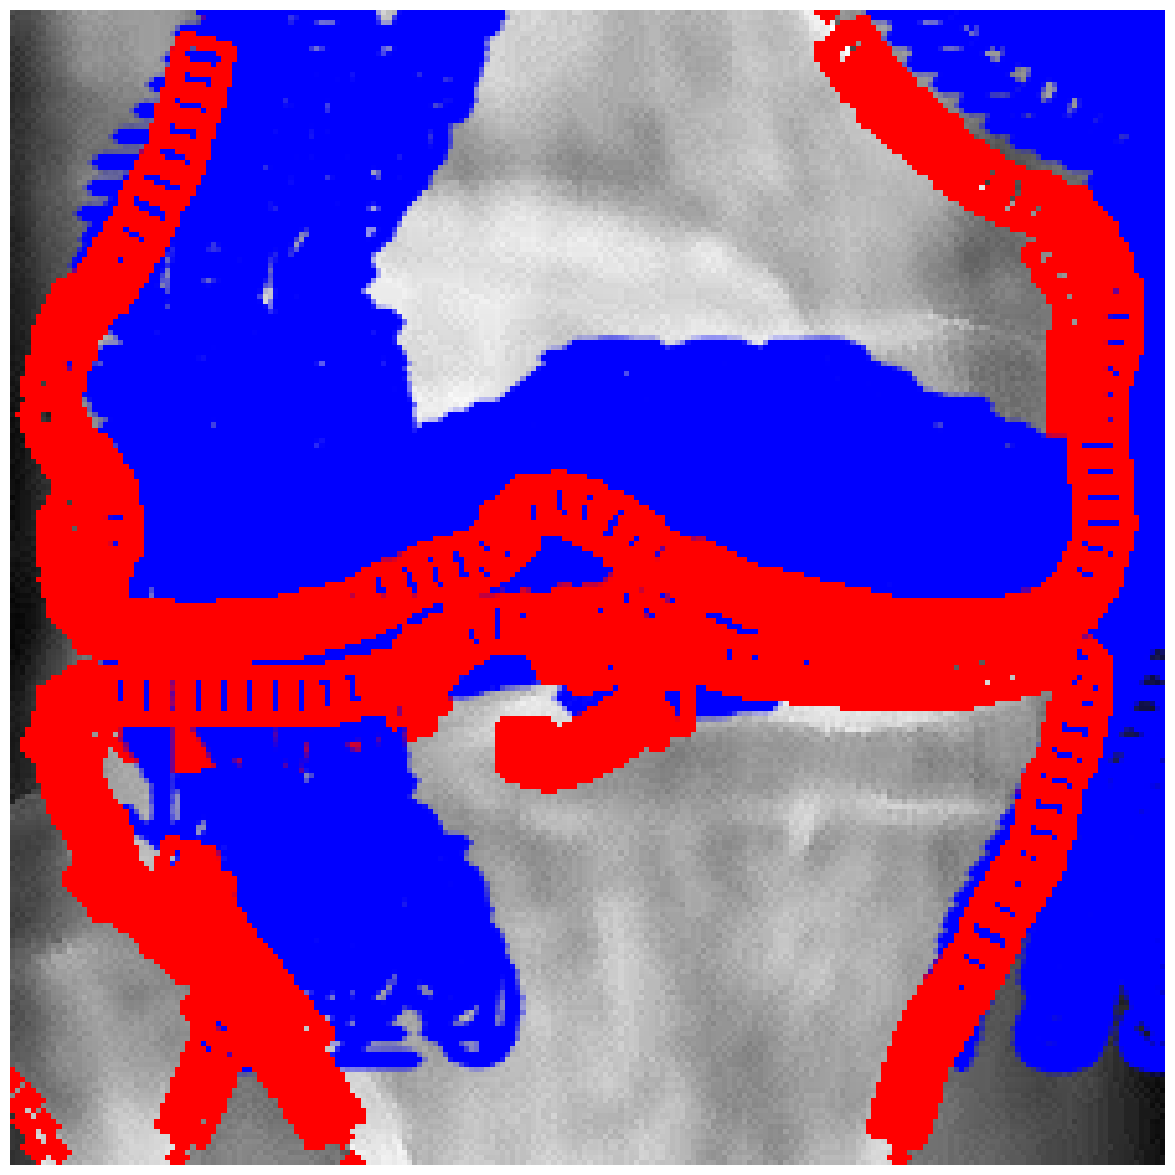

In [63]:
test_img_EdgePatchs, test_img_EdgePatchsInfo = GetEdgePatchs(test_img, test_img_EdgePoints, PatchSize=9, draw=True)

In [64]:
test_img_EdgeVecs = EdgePatchs2EdgeVecs(test_img_EdgePatchs, draw=True)

EdgeVecs boyutu: (413, 33)


In [65]:
unique_vector = LoadUniqueVectors(filename=r"C:\Users\Eren\Desktop\hog_kenar_kayit\k_capli_kenar_unique_vectors.pkl")

TrueEdgePoints = Match(unique_vector, test_img_EdgeVecs, test_img_EdgePoints)

40 vektör C:\Users\Eren\Desktop\hog_kenar_kayit\k_capli_kenar_unique_vectors.pkl dosyasından yüklendi.


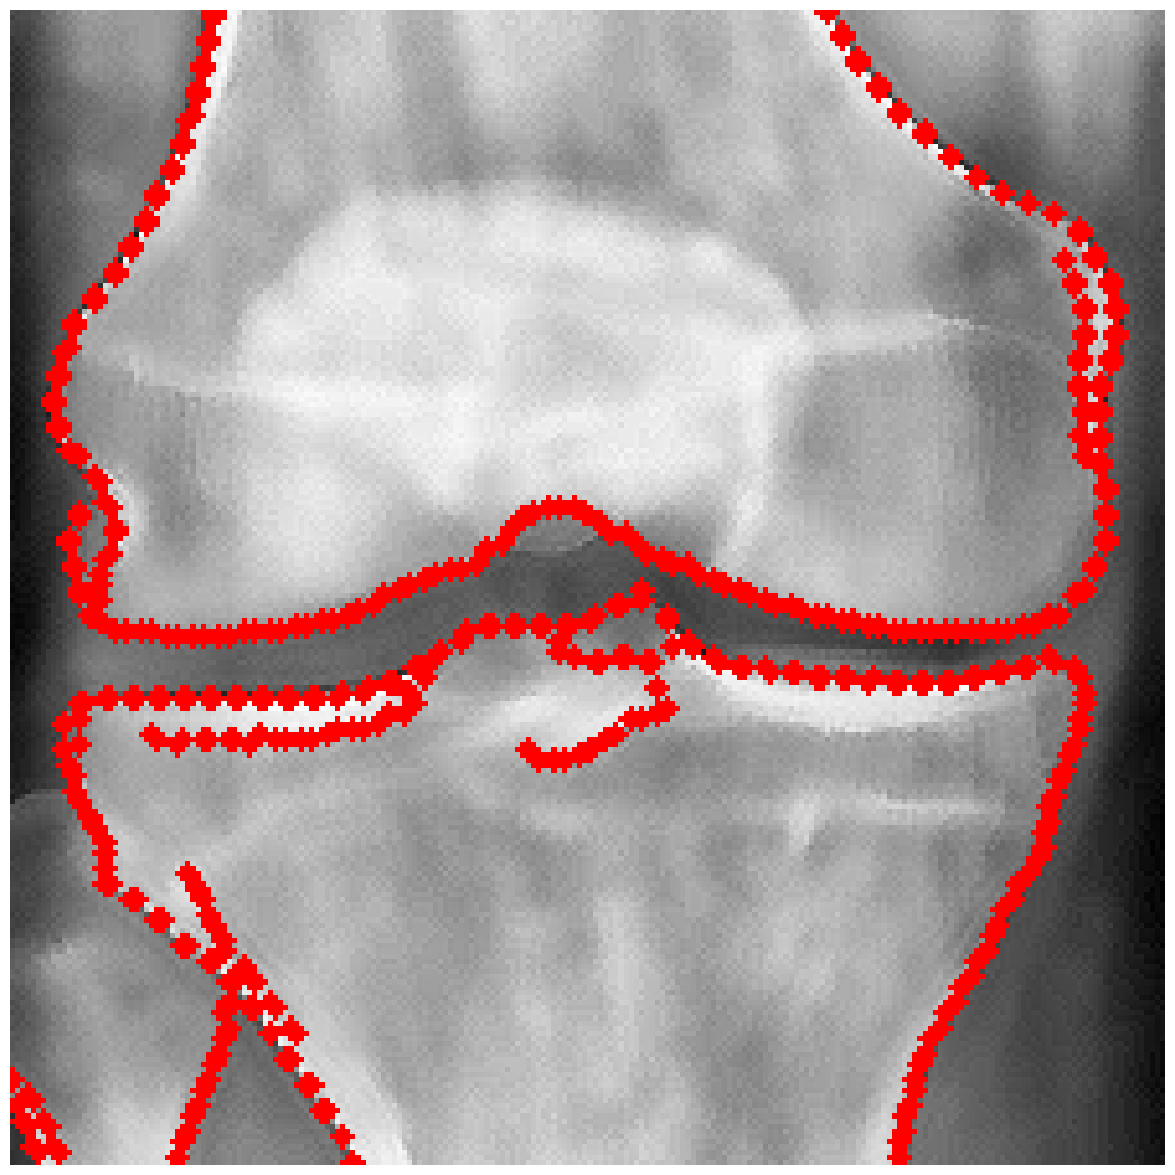

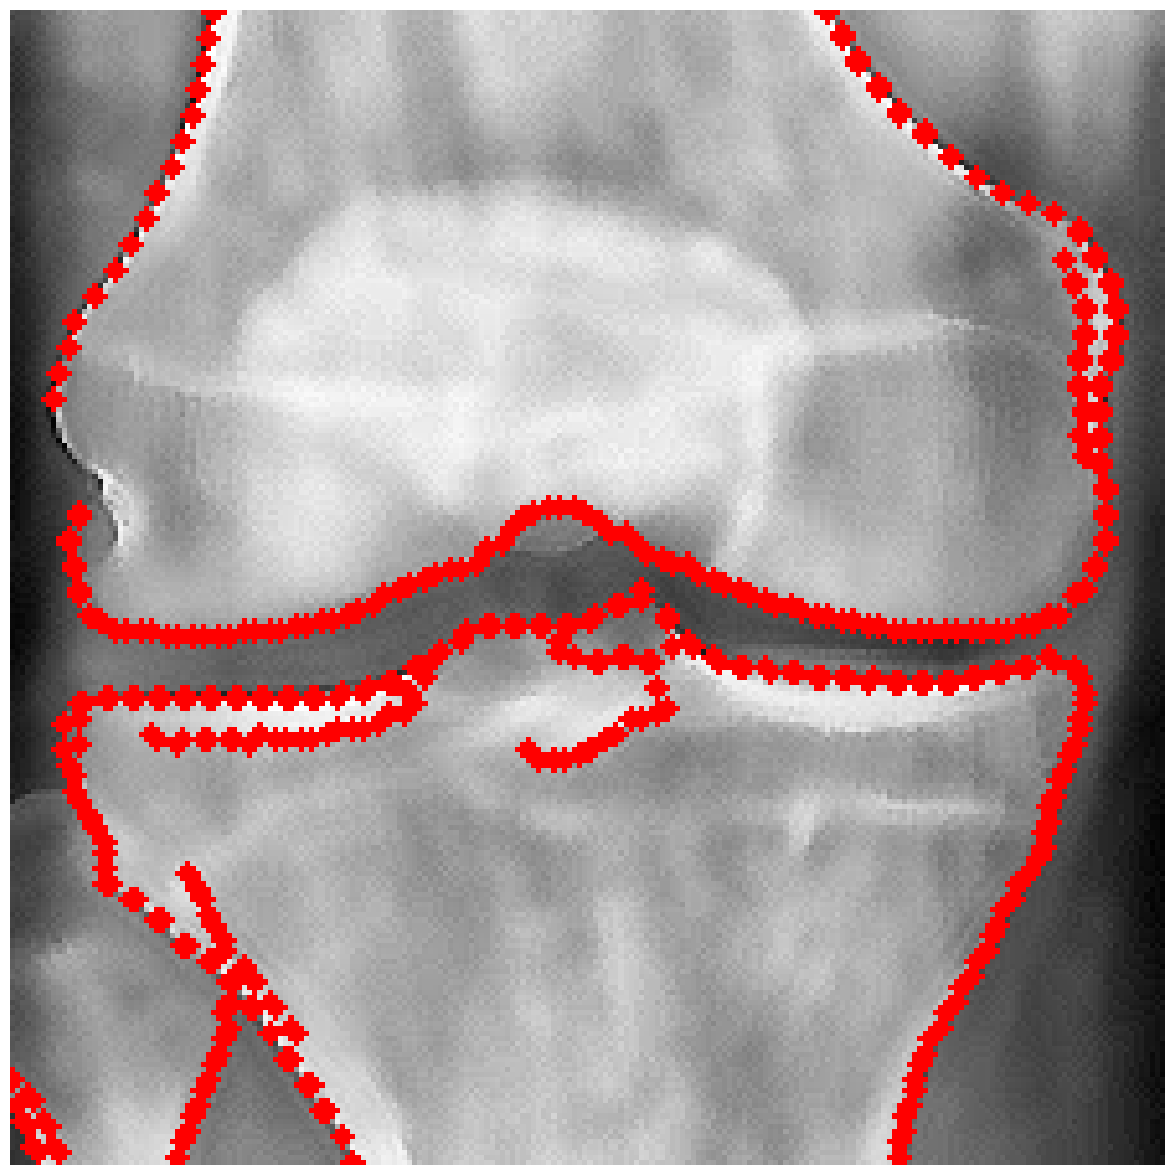

In [66]:
Drawing(test_img, EdgePoints=test_img_EdgePoints)

Drawing(test_img, EdgePoints=TrueEdgePoints)

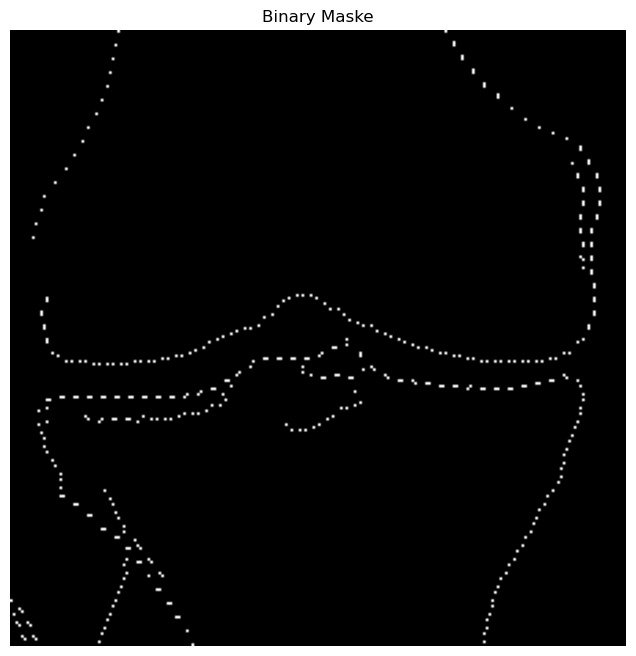

In [71]:
def create_binary_mask(img_shape, edge_points):
    """
    Kenar noktalarını (EdgePoints) kullanarak binary bir maske oluşturur.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y,x) formatındaki koordinat listesi.

    Returns:
    - mask: Binary maske (aynı boyutlarda, kenar noktaları 1, geri kalanı 0).
    """
    # Boş bir maske oluştur (0 değerleriyle)
    mask = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını maske üzerinde işaretle
    for y, x in edge_points:
        mask[y, x] = 255  # Noktaları beyaz yap

    return mask

test_image_shape = test_img.shape

TrueEdgePointss = TrueEdgePoints

binary_mask = create_binary_mask(test_image_shape, TrueEdgePointss)

plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Maske")
plt.axis('off')
plt.show()

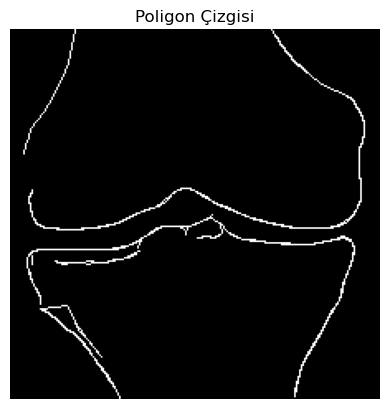

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance, min_line_length, min_component_size):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez,
    belirli bir uzunluktan kısa olan çizgileri çizmez ve küçük ayrık bileşenleri saf dışı bırakır.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.
    - min_line_length: Çizilecek minimum çizgi uzunluğu.
    - min_component_size: Görüntüde kalmasına izin verilen minimum bileşen boyutu (piksel sayısı).

    Returns:
    - contour_img: Kenar çizgileri çizilmiş ve küçük bileşenler kaldırılmış bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse ve çizgi uzunluğu yeterliyse çizgi çiz
        if distance <= max_distance and distance >= min_line_length:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    # Bağlı bileşen analizi ile küçük bileşenleri kaldır
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(contour_img, connectivity=8)

    # Yeni bir görüntü oluştur ve sadece büyük bileşenleri ekle
    filtered_img = np.zeros_like(contour_img)
    for i in range(1, num_labels):  # 0 etiket arka plan olduğu için atlanır
        if stats[i, cv2.CC_STAT_AREA] >= min_component_size:
            filtered_img[labels == i] = 255

    return filtered_img

# Örnek kullanım
# Örnek veri (test_image_shape ve TrueEdgePointss'i kullanıcı sağlamalı)
# test_image_shape = (512, 512)
# TrueEdgePointss = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 20
# min_line_length = 10
# min_component_size = 50  # Minimum bileşen boyutu (piksel sayısı)
test_image_shape = test_img.shape
contour_img = draw_contour(test_image_shape, TrueEdgePoints, max_distance=20, min_line_length=5, min_component_size=65)
plt.imshow(contour_img, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()

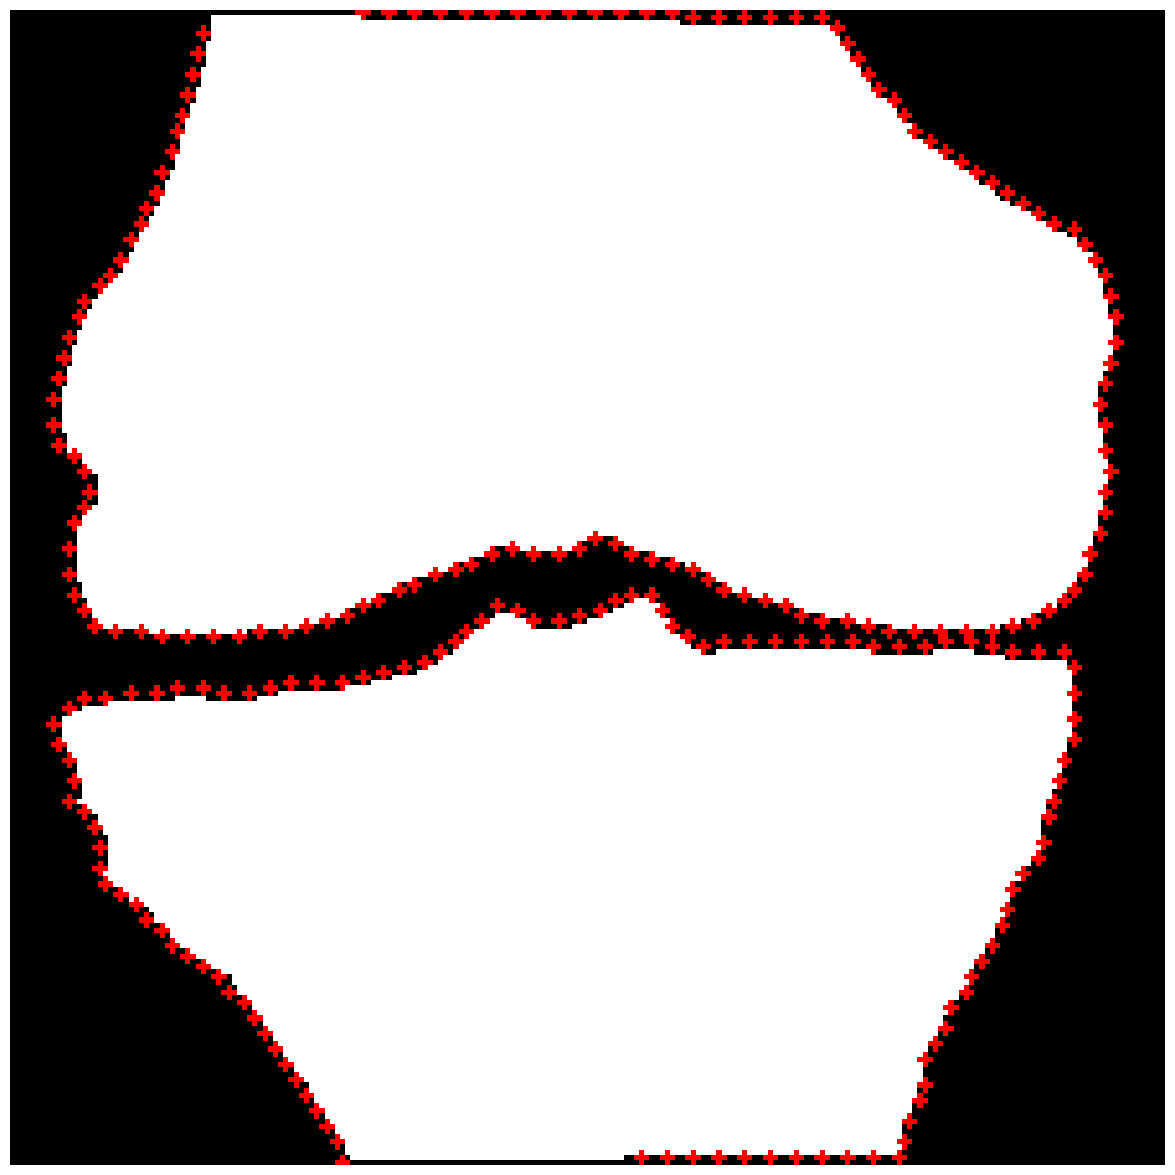

In [68]:
testlabel_EdgePoints = GetLabelEdgePoints(test_label, sparsity_factor=5,circle_radius=1, draw=True)

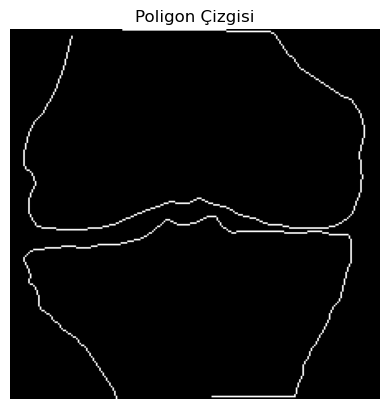

In [69]:
test_label_shape = test_label.shape

import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_contour(img_shape, edge_points, max_distance):
    """
    Kenar noktalarından birleştirilmiş bir kontur çizgisi oluşturur. Ancak, belirli bir mesafeden uzak olan noktaları birleştirmez.

    Args:
    - img_shape: Orijinal görüntünün boyutları (yükseklik, genişlik).
    - edge_points: Kenar noktalarının (y, x) formatındaki listesi.
    - max_distance: Birleştirme için izin verilen maksimum mesafe.

    Returns:
    - contour_img: Kenar çizgileri çizilmiş bir görüntü.
    """
    # Boş bir görüntü oluştur
    contour_img = np.zeros(img_shape, dtype=np.uint8)

    # Kenar noktalarını birleştirerek çizgi çiz
    for i in range(len(edge_points) - 1):
        start_point = tuple(edge_points[i][::-1])  # (x, y) formatına çevir
        end_point = tuple(edge_points[i + 1][::-1])

        # Öklid mesafesini hesapla
        distance = np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2)

        # Eğer mesafe eşik değerden küçükse çizgi çiz
        if distance <= max_distance:
            cv2.line(contour_img, start_point, end_point, 255, 1)  # Beyaz çizgi

    return contour_img

# Örnek kullanım
# Örnek veri (test_label_shape ve testlabel_EdgePoints'i kullanıcı sağlamalı)
# test_label_shape = (512, 512)
# testlabel_EdgePoints = [(10, 10), (50, 50), (300, 300), (350, 350)]
# max_distance = 100

contour_label = draw_contour(test_label_shape, testlabel_EdgePoints, max_distance=50)
plt.imshow(contour_label, cmap='gray')
plt.title("Poligon Çizgisi")
plt.axis('off')
plt.show()

IoU: 0.1871


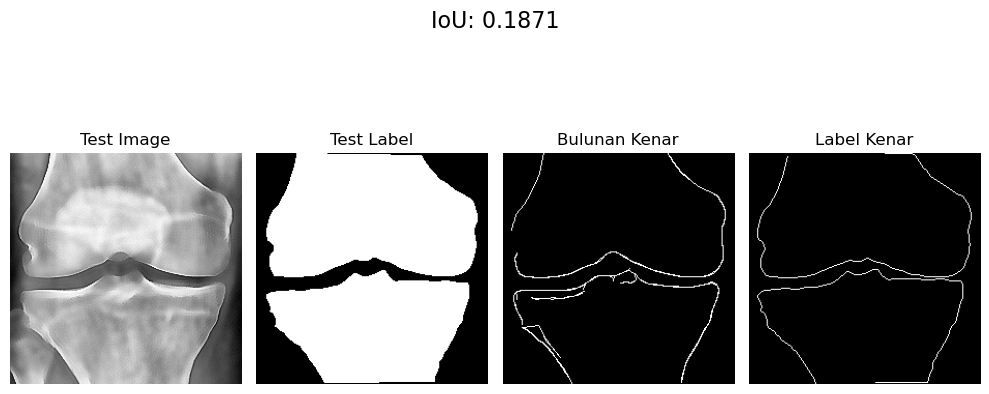

In [70]:
import numpy as np

def calculate_iou(binary_image1, binary_image2):
    """
    İki binary görüntü arasındaki Intersection over Union (IoU) değerini hesaplar.

    Args:
    - binary_image1: İlk binary görüntü (numpy array).
    - binary_image2: İkinci binary görüntü (numpy array).

    Returns:
    - IoU: İki görüntü arasındaki IoU değeri.
    """
    # Kesişim ve birleşim hesaplama
    intersection = np.logical_and(binary_image1, binary_image2).sum()
    union = np.logical_or(binary_image1, binary_image2).sum()

    # IoU hesaplama
    if union == 0:
        return 0  # Birleşim sıfırsa IoU tanımsızdır, bu nedenle 0 döndürüyoruz.
    iou = intersection / union
    return iou

# Örnek kullanım
# binary_image1 ve binary_image2'nin aynı boyutta olduğunu varsayıyoruz
# binary_image1 = np.array(...)  # İlk binary görüntü
# binary_image2 = np.array(...)  # İkinci binary görüntü

iou_value = calculate_iou(contour_img, contour_label)
print(f"IoU: {iou_value:.4f}")

# Görselleştirme
plt.figure(figsize=(10, 5))
# IoU başlığı
plt.suptitle(f"IoU: {iou_value:.4f}", fontsize=16)

# Bulunan kontur görüntüsü
plt.subplot(1, 4, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 2)
plt.imshow(test_label, cmap='gray')
plt.title("Test Label")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(contour_img, cmap='gray')
plt.title("Bulunan Kenar")
plt.axis('off')

# Etiket kontur görüntüsü
plt.subplot(1, 4, 4)
plt.imshow(contour_label, cmap='gray')
plt.title("Label Kenar")
plt.axis('off')

plt.tight_layout()
plt.show()